# Import Libraries & Set Up
---

In [1]:
import warnings
import logging
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import bnlearn as bn
from pgmpy.global_vars import logger
from utils import * # Helper functions

In [2]:
warnings.filterwarnings('ignore')
logger.setLevel(logging.ERROR)
logging.getLogger('seaborn').setLevel(logging.ERROR)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logging.getLogger('pandas').setLevel(logging.ERROR)

palette = ['#800080', '#8A2BE2', '#FF69B4', '#DA70D6', '#9370DB', '#DDA0DD', '#BA55D3']
gradient_palette = sns.light_palette('#620080', as_cmap=True)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
sns.set_theme(style="whitegrid", palette=palette)

# Dementia
---

Let's import the processed dataset.

In [3]:
dementia_df = pd.read_csv('data/dementia_data_processed.csv')

## Discretising the Data
---

To prepare the data for a discrete BN, we must first discretise the data into bins.

In [4]:
dementia_df_5bins = discretise(dementia_df.copy(), nbins=5)
dementia_df_sturges = discretise(dementia_df.copy(), method='sturges')
dementia_df_freedman_diaconis = discretise(dementia_df.copy(), method='freedman-diaconis')

Then we can plot this discretised data to see the effects.

### 5 Bin Discretisation
---

In [5]:
dementia_df_5bins.head()

Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
0      0      0         0    0    3     2    1     4    0     4     1    0
1      0      1         0    0    3     2    1     4    0     4     0    0
2      1      0         0    0    1     1    0     3    0     3     2    1
3      1      1         1    0    2     1    0     4    0     3     1    0
4      1      2         3    0    2     1    1     3    0     3     1    1

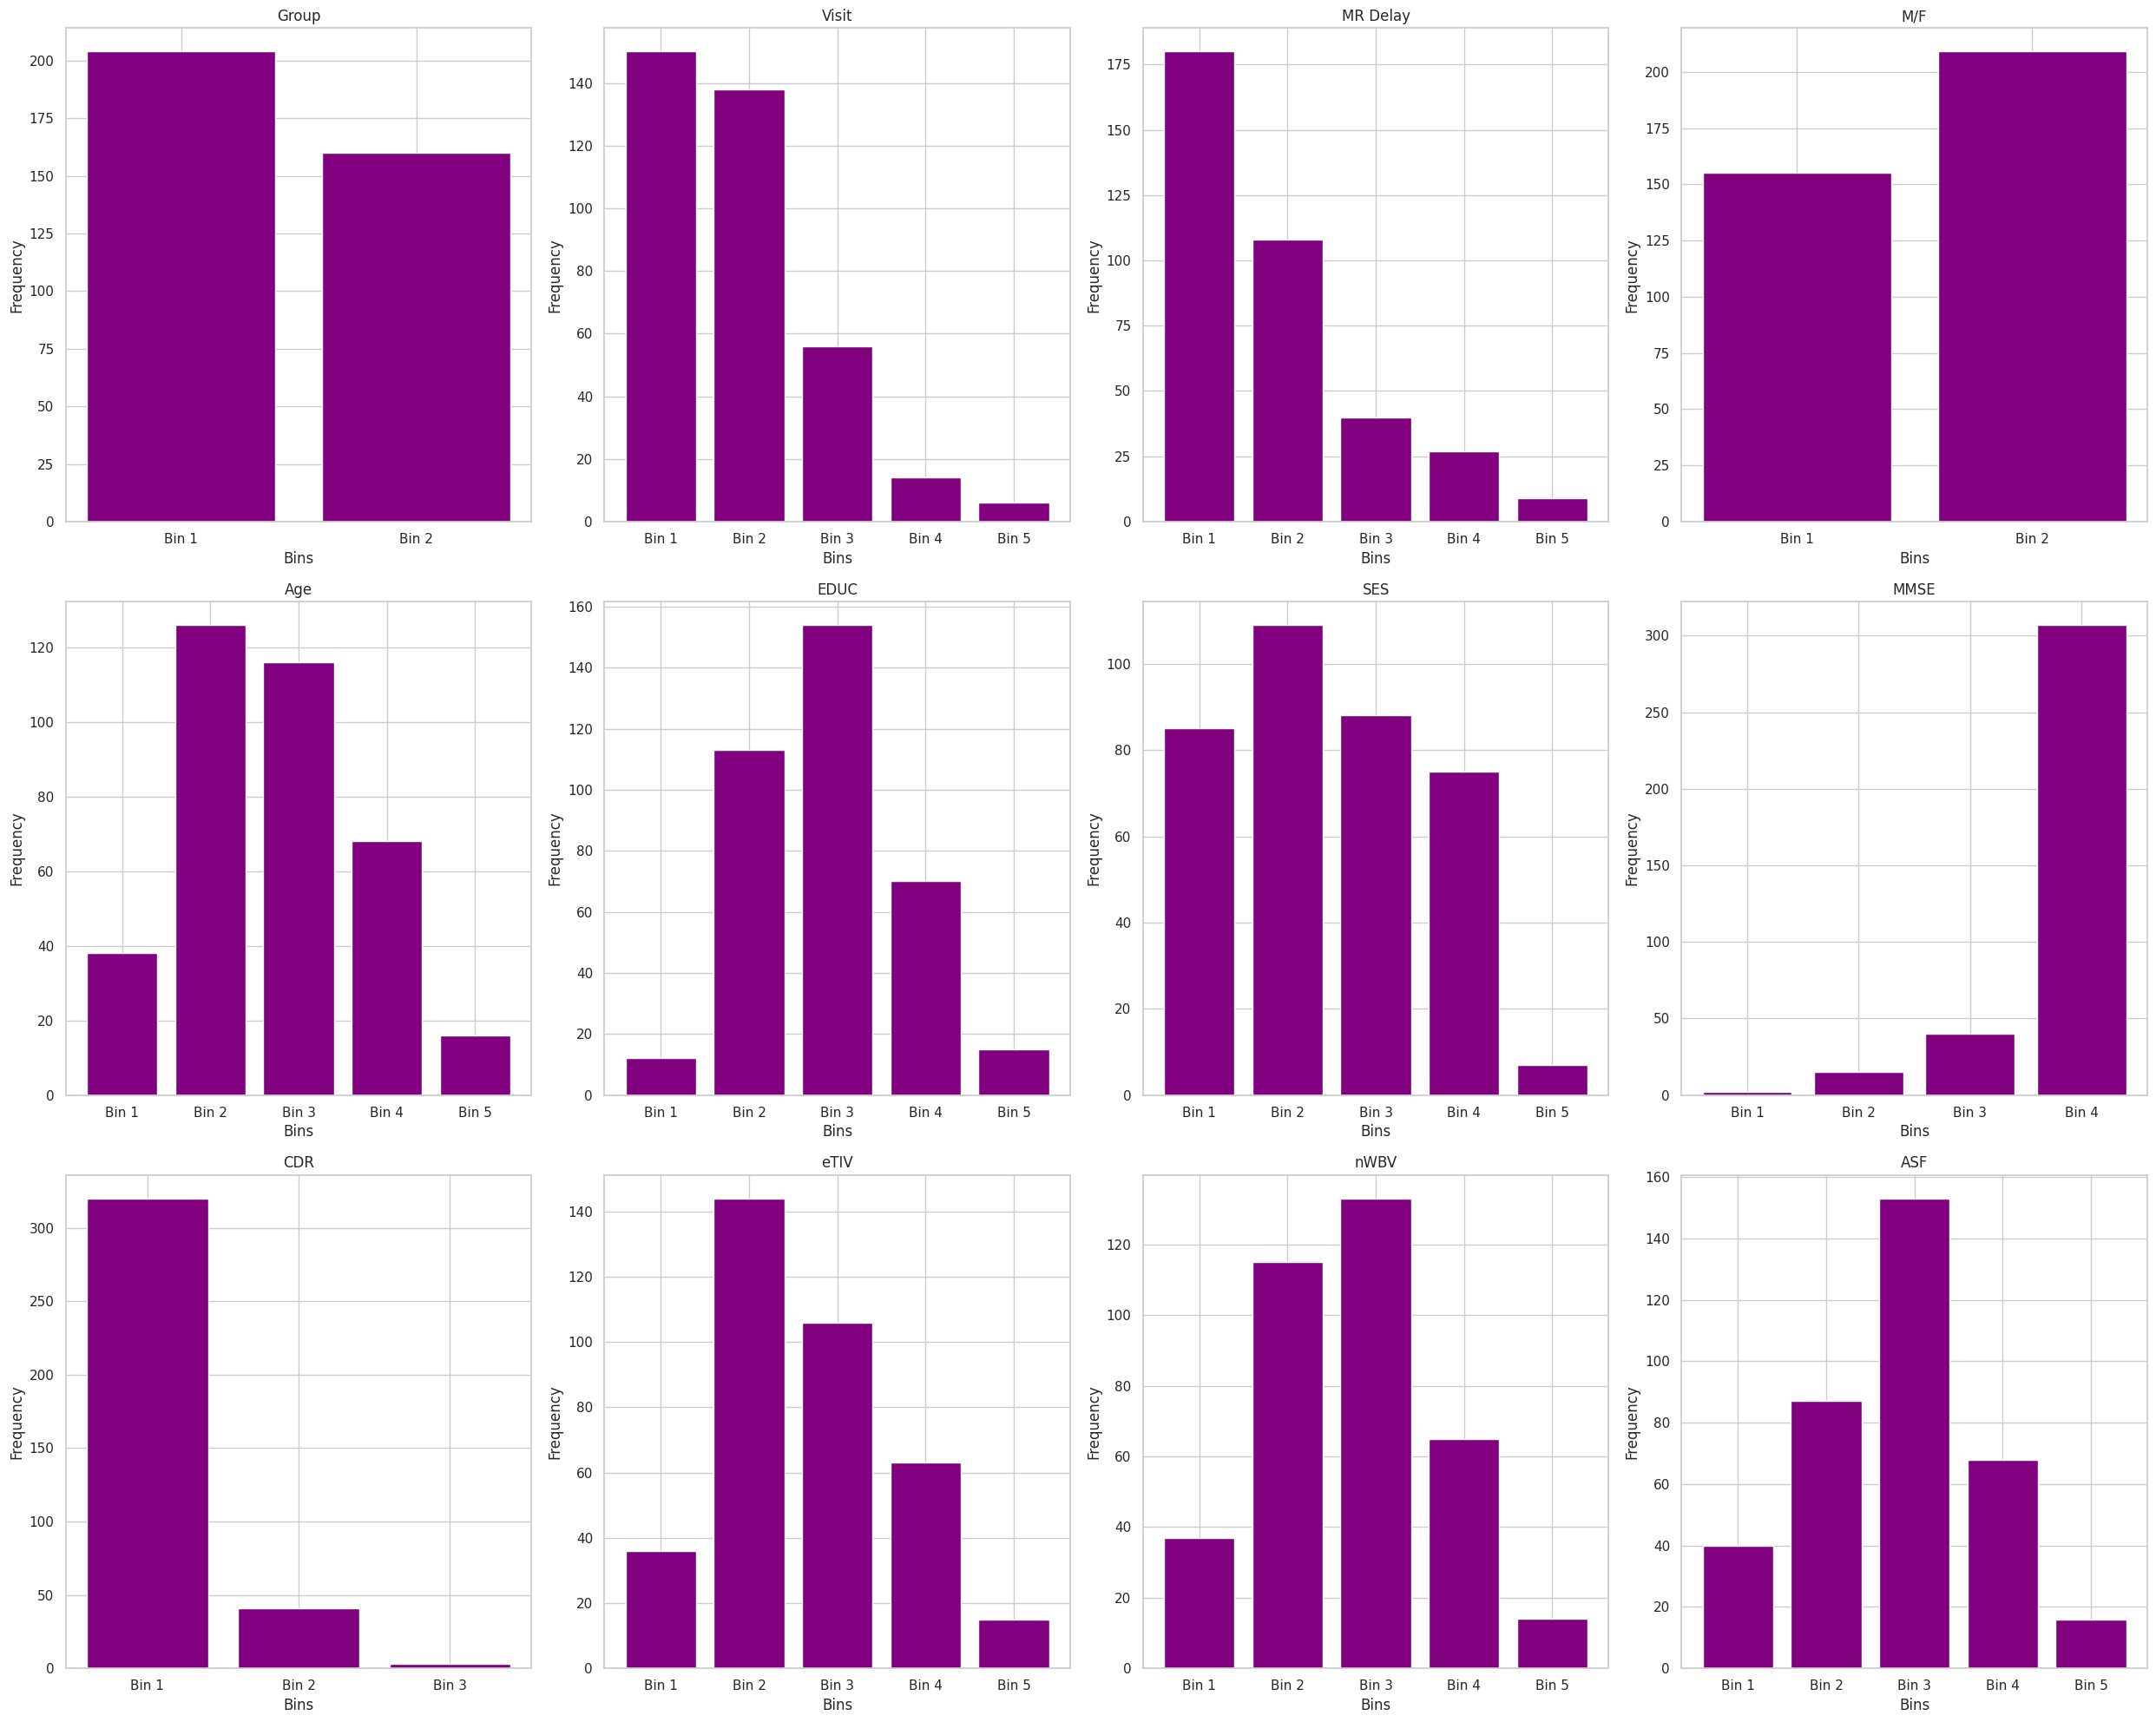

In [6]:
plot_bins_barcharts(dementia_df_5bins)

### Sturges Formula Discretisation
---

In [7]:
dementia_df_sturges.head()

Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
0      0      0         0    0    7     4    2     8    0     9     2    0
1      0      1         1    0    7     4    2     9    0     9     1    0
2      1      0         0    0    3     3    1     7    0     6     4    2
3      1      1         2    0    4     3    1     9    0     7     3    1
4      1      2         7    0    5     3    3     6    0     6     2    2

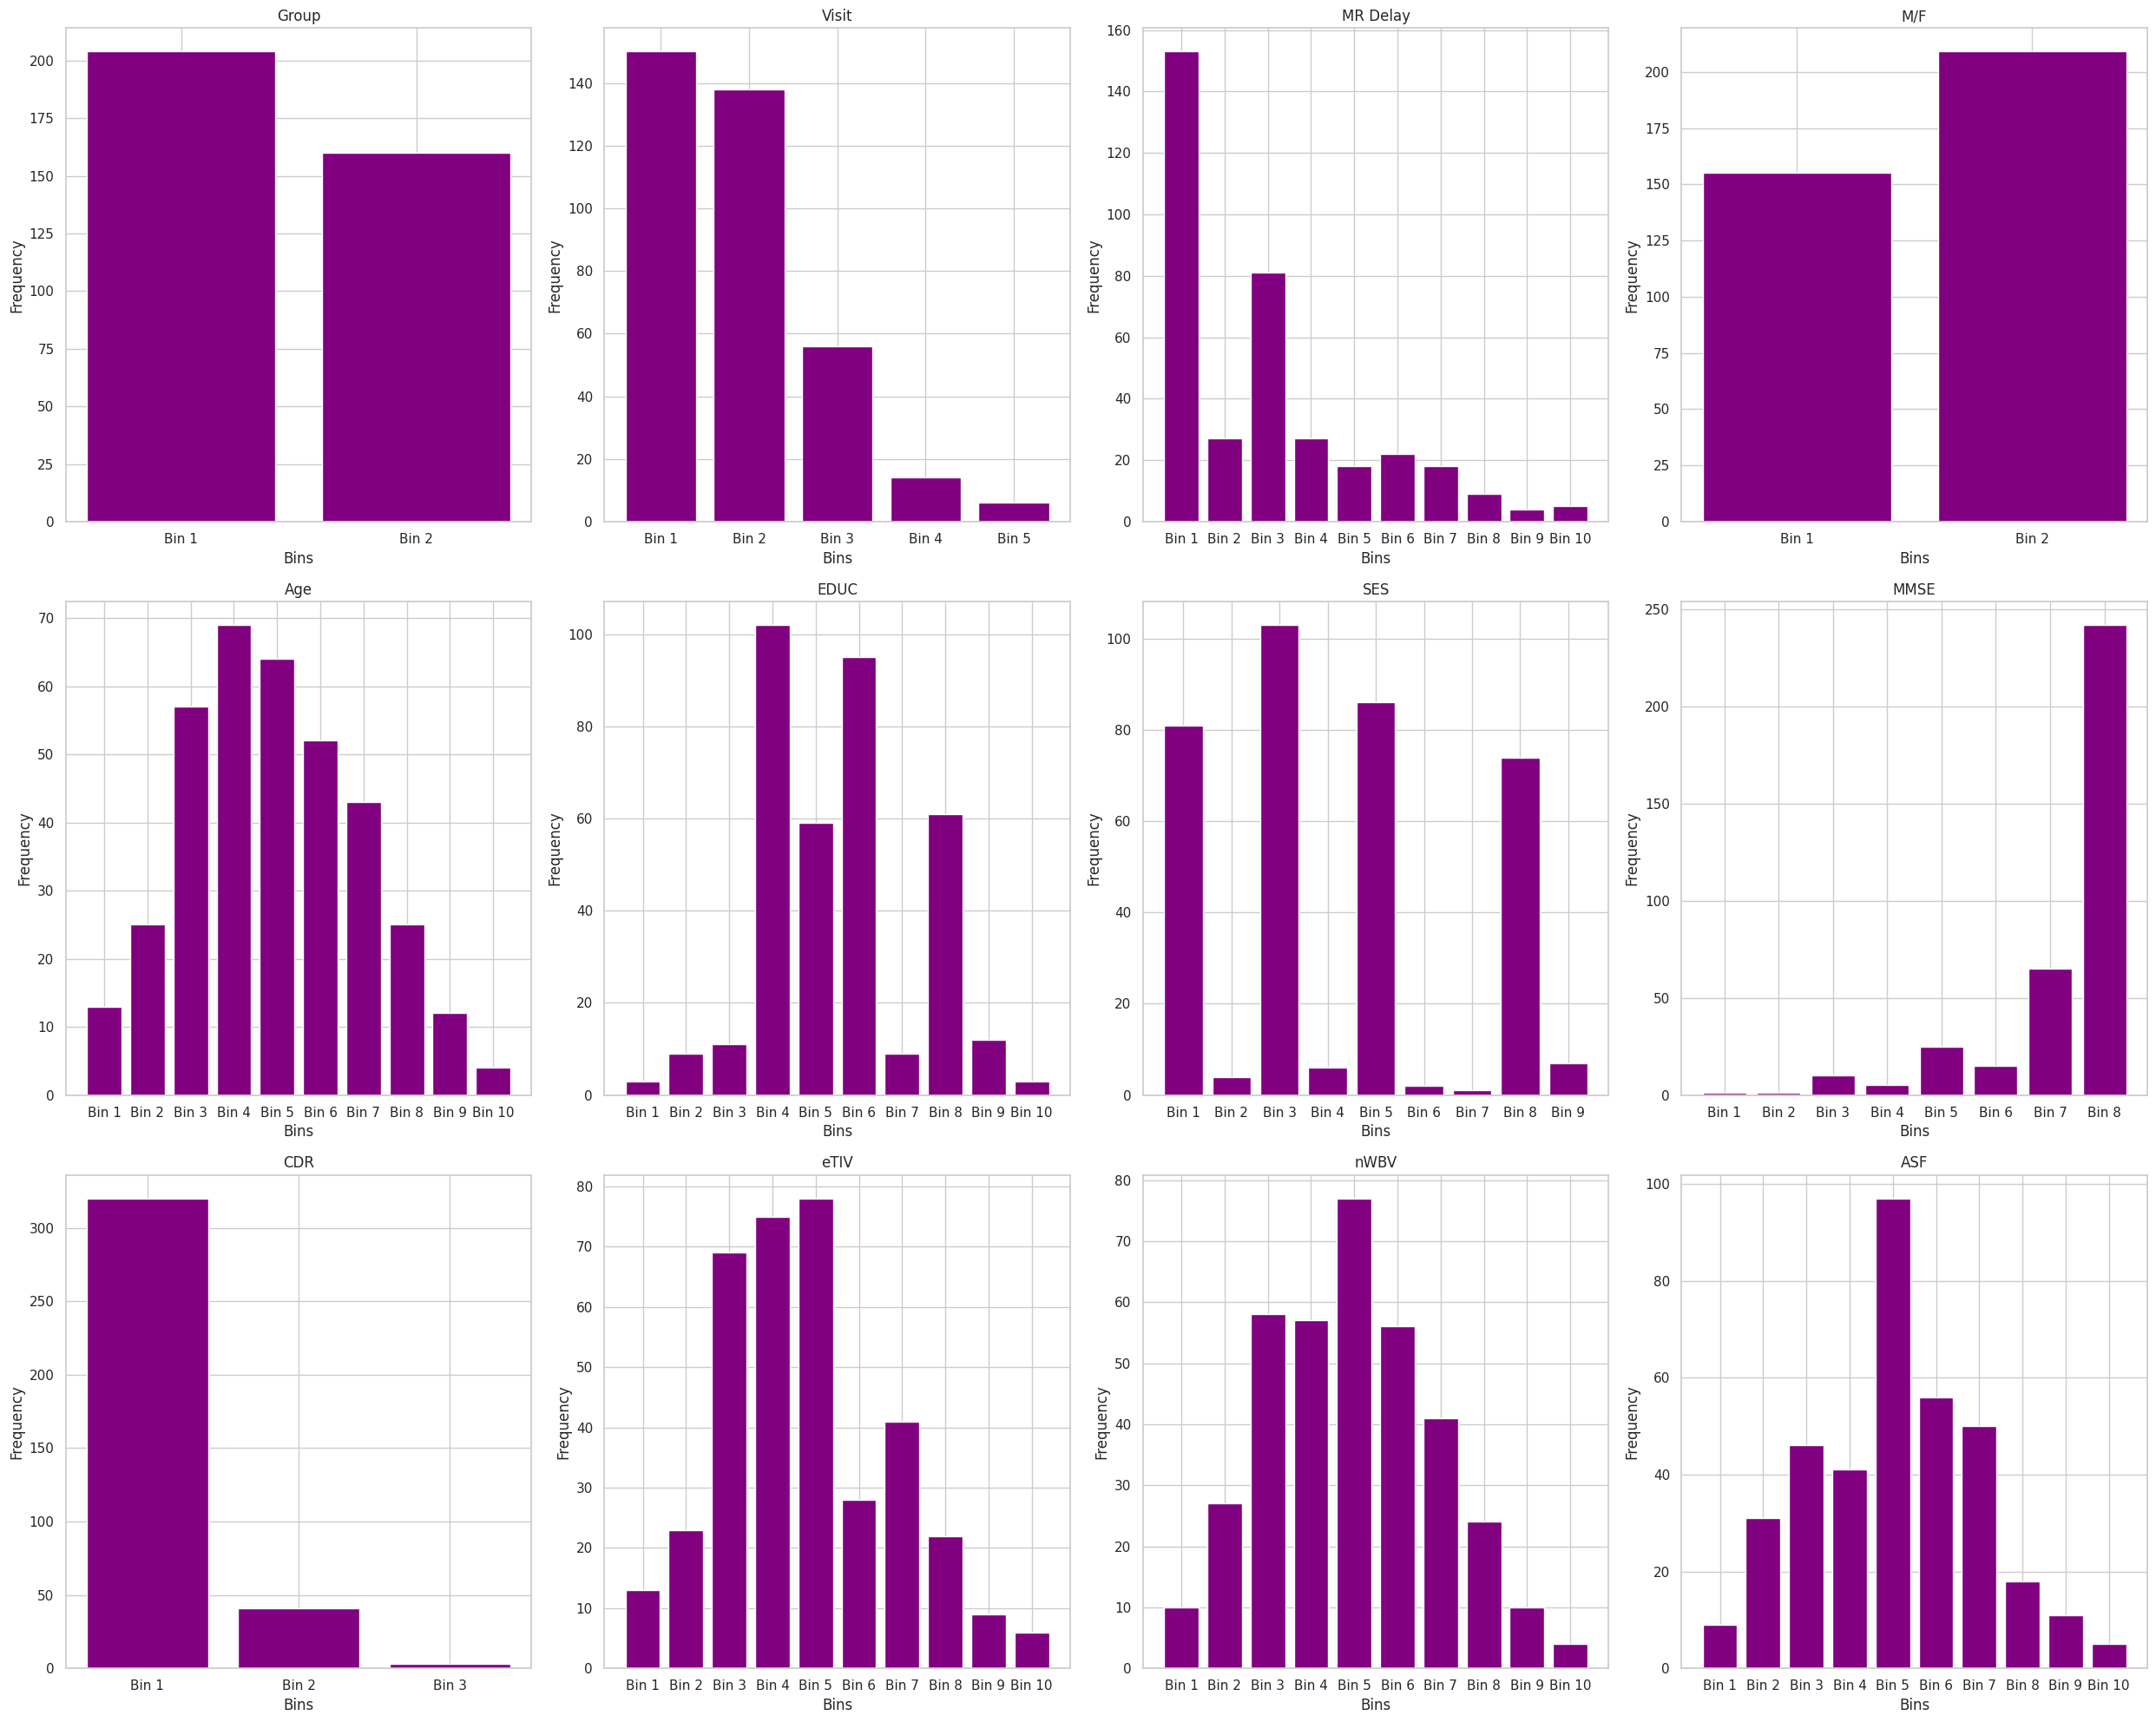

In [8]:
plot_bins_barcharts(dementia_df_sturges)

### Freedman Diaconis Rule Discretisation
---

In [9]:
dementia_df_freedman_diaconis.head()

Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
0      0      0         0    0    9     5    3    16    0    13     3    0
1      0      1         1    0    9     5    3    18    0    13     2    0
2      1      0         0    0    5     4    2    13    0     8     6    3
3      1      1         2    0    5     4    1    17    0     9     4    2
4      1      2         7    0    6     4    5    13    0     9     3    3

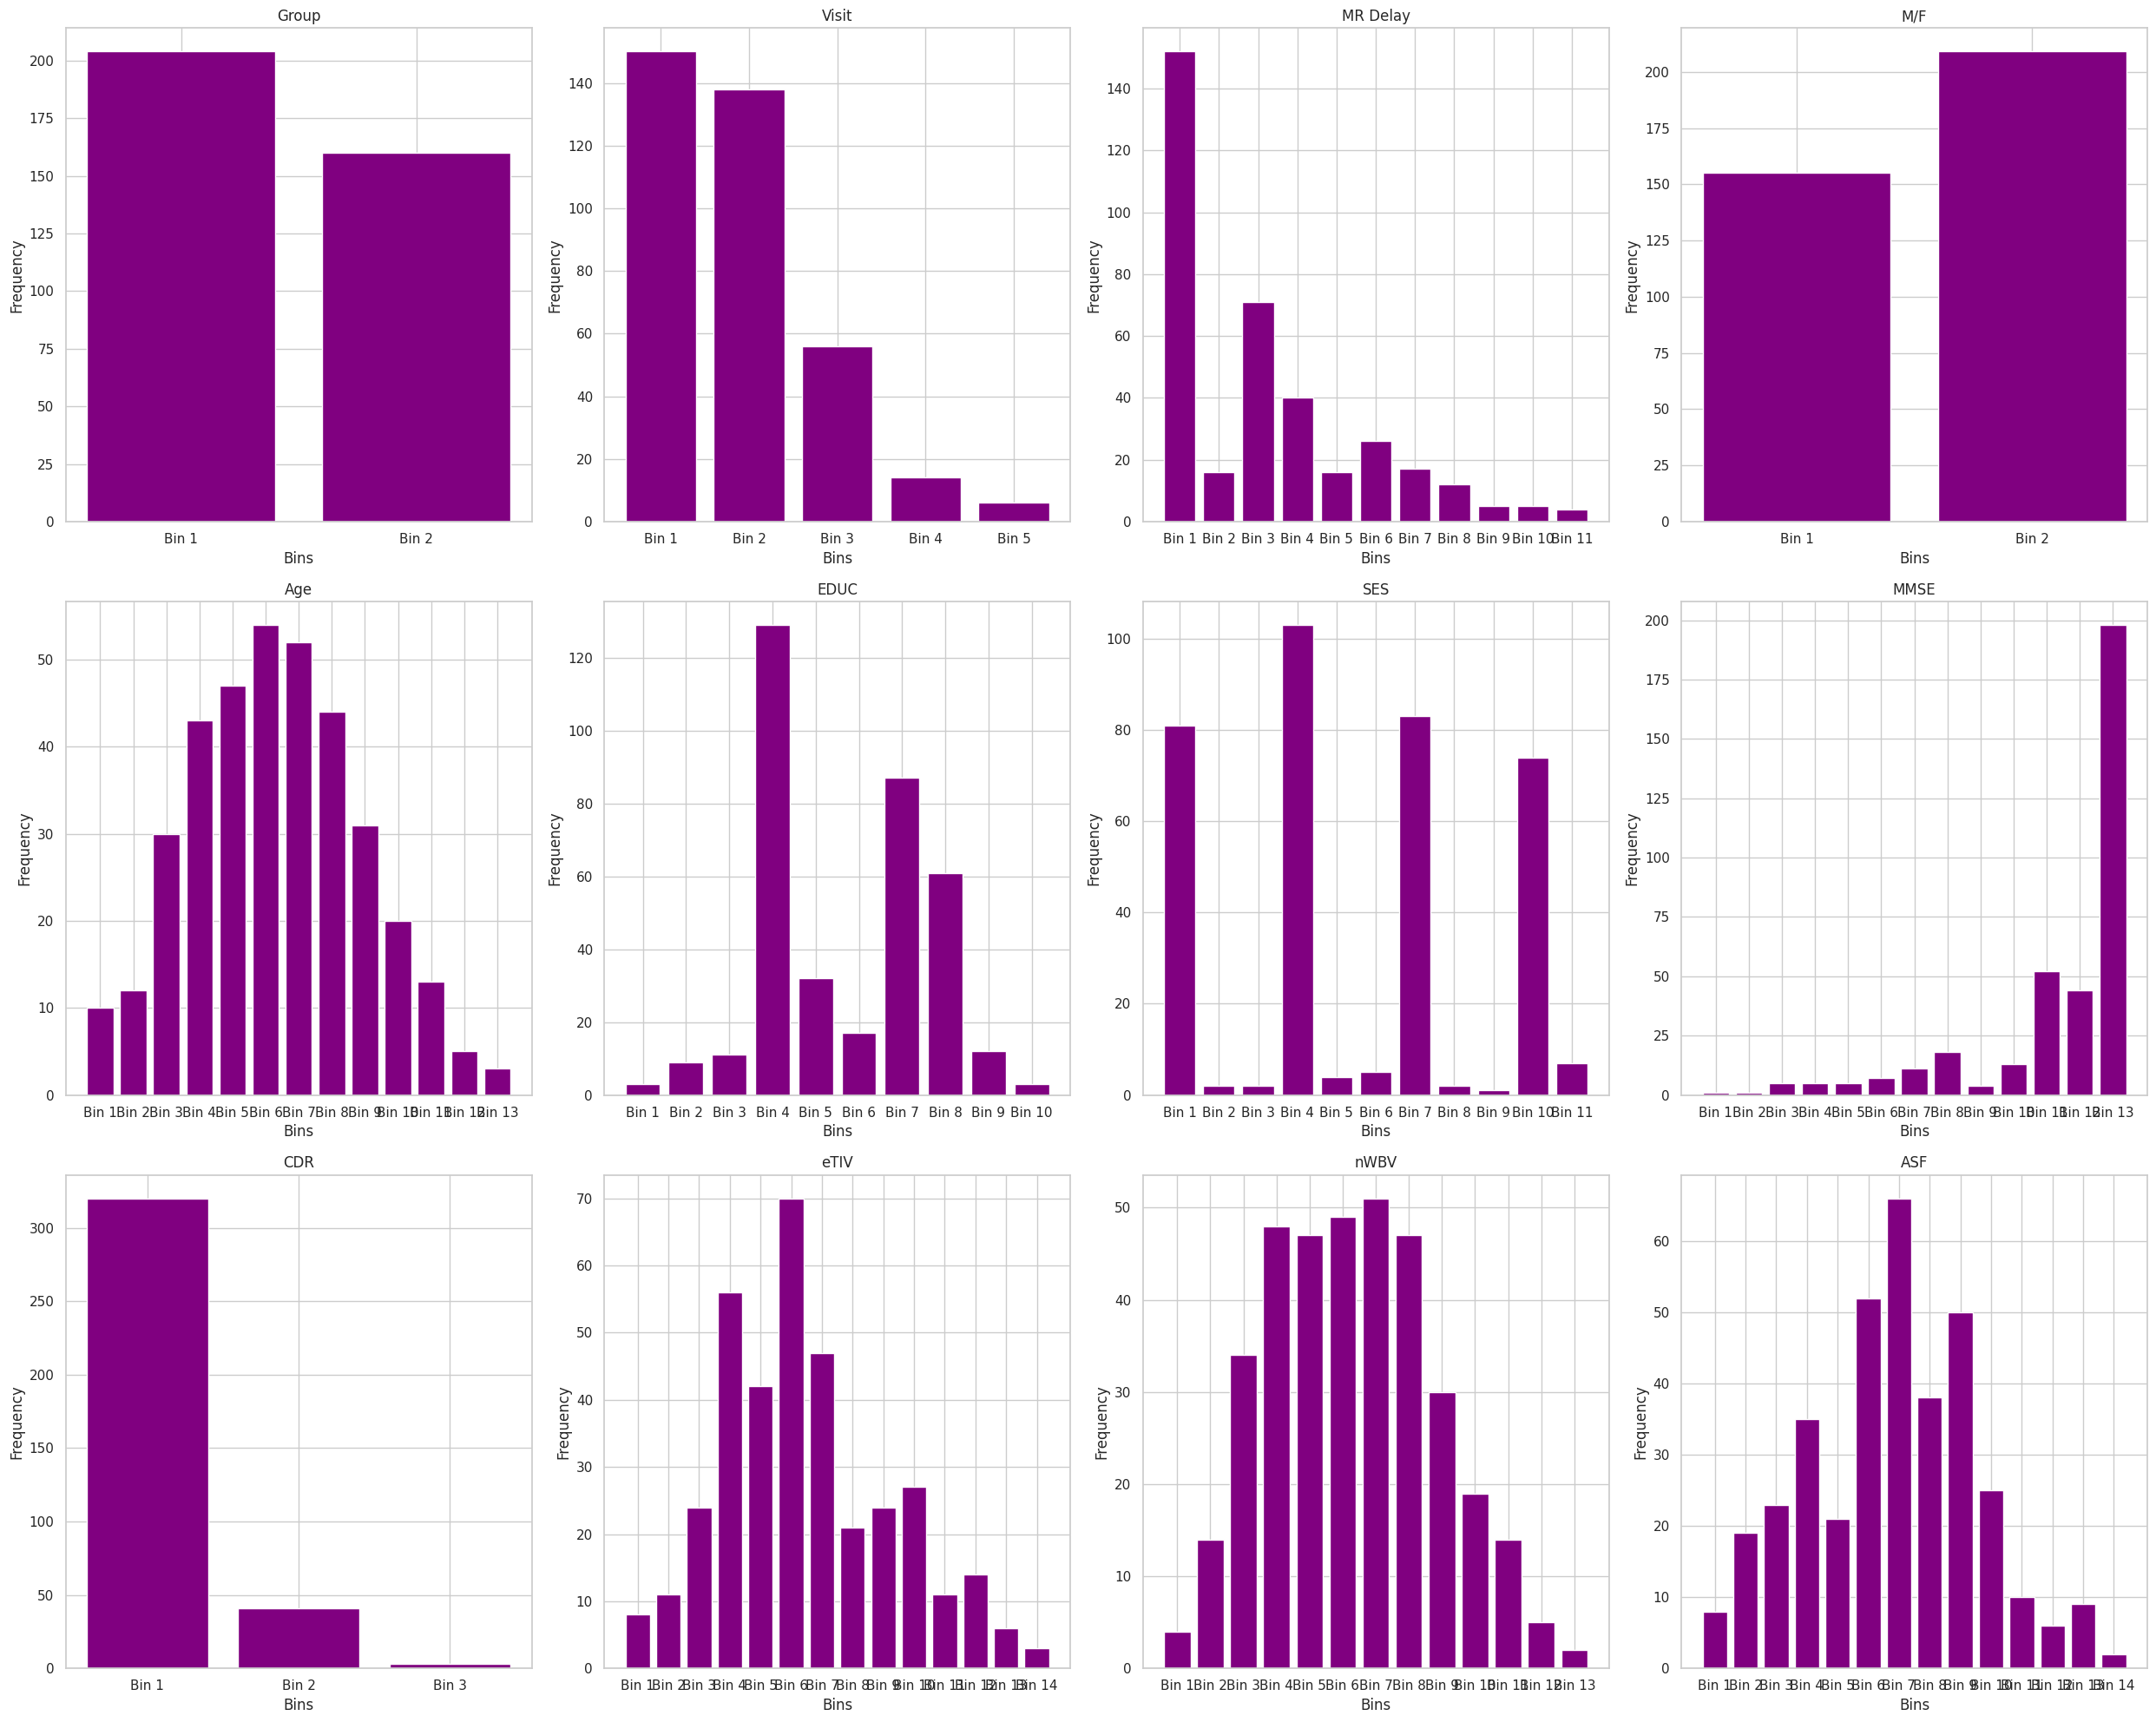

In [10]:
plot_bins_barcharts(dementia_df_freedman_diaconis)

### Comparing Discretisation Methods
---

Visually we can see that the Freedman-Diaconis Rule seemingly performs well compared to the other methods, without much extra computation needed. We can verify this by checking the Mean Squared Error (MSE) in comparison to the original, continuous data.

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
mse_5bins = mean_squared_error(dementia_df, dementia_df_5bins)
mse_sturges = mean_squared_error(dementia_df, dementia_df_sturges)
mse_freedman_diaconis = mean_squared_error(dementia_df, dementia_df_freedman_diaconis)

In [13]:
mse_values = [mse_5bins, mse_sturges, mse_freedman_diaconis]

Now we can visualise the MSE scores of each method (the lower the better).

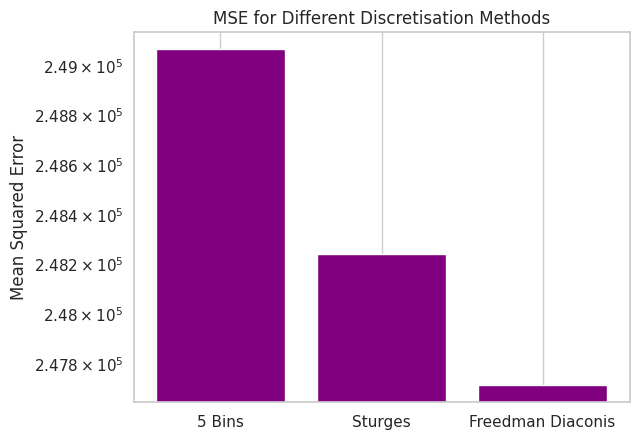

In [14]:
plt.bar(['5 Bins', 'Sturges', 'Freedman Diaconis'], mse_values)
plt.title('MSE for Different Discretisation Methods')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.show()

As observed, the Freedman-Diaconis method yields the best performance among the four discretisation methods. However, the significantly high MSE score suggests that discretising the data may not be the most effective approach for this dataset. This indicates that using discrete Bayesian Networks (BNs) could be introducing substantial information loss.

In [15]:
dementia_df = dementia_df_freedman_diaconis.copy()
dementia_df.describe().T

count       mean       std  min   25%   50%   75%   max
Group     364.0   0.439560  0.497017  0.0   0.0   0.0   1.0   1.0
Visit     364.0   0.868132  0.923627  0.0   0.0   1.0   1.0   4.0
MR Delay  364.0   2.151099  2.465570  0.0   0.0   2.0   3.0  10.0
M/F       364.0   0.574176  0.495148  0.0   0.0   1.0   1.0   1.0
Age       364.0   5.296703  2.559461  0.0   3.0   5.0   7.0  12.0
EDUC      364.0   5.653846  1.998887  0.0   4.0   5.0   7.0  11.0
SES       364.0   4.467033  3.325585  0.0   3.0   3.0   6.0  12.0
MMSE      364.0  16.414835  2.630799  0.0  16.0  18.0  18.0  18.0
CDR       364.0   0.137363  0.410375  0.0   0.0   0.0   0.0   3.0
eTIV      364.0   5.450549  2.791225  0.0   3.0   5.0   7.0  13.0
nWBV      364.0   5.285714  2.506348  0.0   3.0   5.0   7.0  12.0
ASF       364.0   5.771978  2.756447  0.0   4.0   6.0   8.0  13.0

## Learning Structure & Parameters with Cross-Validation
---

Now we will explore the process of structure learning and parameter learning for Bayesian Networks (BNs) using the provided dataset. We will evaluate multiple structure learning methods, perform parameter learning, and assess the results using cross-validation.

Our goals are:
1. To understand the structure of the data using various structure learning algorithms.
2. To learn the parameters of the best structure.
3. To evaluate the performance of each method through cross-validation.

The methods we will use:
1. Tree-Augmented Naive Bayes (TAN)
2. Hill Climbing (HC) with BDeu scoring
3. PC Algorithm

We will then evaluate each method's performance and compare the results.

### Cross-Validation
---

In utils we have defined a function for cross validation, and we can run for each different type of model we want to test to see which one gets the best results.

In [16]:
metrics = {}
confusion = {}

#### Tree-Augmented Naive Bayes
---

In [17]:
structure_kwargs_tan = {'methodtype': 'tan', 'class_node': 'Group'}

##### Bayes

In [18]:
metrics_tan_bayes, confusion_tan_bayes = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+---------------------+---------------------+
| Group    | Group(0)            | Group(1)            |
+----------+---------------------+---------------------+
| eTIV(0)  | 0.05999136814846786 | 0.06313876902112198 |
+----------+---------------------+---------------------+
| eTIV(1)  | 0.05848079413034097 | 0.06154894390188509 |
+----------+---------------------+---------------------+
| eTIV(2)  | 0.07056538627535608 | 0.0710878946173064  |
+----------+---------------------+---------------------+
| eTIV(3)  | 0.08113940440224429 | 0.090165796048149   |
+----------+---------------------+---------------------+
| eTIV(4)  | 0.0796288303841174  | 0.0806268453327277  |
+----------+---------

100%|██████████| 1/1 [00:00<00:00, 547.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 693.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 613.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 662.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 672.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 390.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 376.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 353.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 382.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 360.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 359.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 401.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 324.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 332.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 418.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 325.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.79it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of ASF:
+---------+----------------------+----------------------+
| Group   | Group(0)             | Group(1)             |
+---------+----------------------+----------------------+
| ASF(0)  | 0.058304647160068855 | 0.061745272271588075 |
+---------+----------------------+----------------------+
| ASF(1)  | 0.07637693631669537  | 0.06334016860332652  |
+---------+----------------------+----------------------+
| ASF(2)  | 0.07336488812392428  | 0.06812485759854182  |
+---------+----------------------+----------------------+
| ASF(3)  | 0.07185886402753874  | 0.07609933925723401  |
+---------+----------------------+----------------------+
| ASF(4)  | 0.06282271944922549  | 0.07609933925723401  |
+---------

100%|██████████| 1/1 [00:00<00:00, 498.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 668.20it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 75 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
75      1      0         0    0    8     0    9    15    0     3     5    9
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 76 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
76      1      1         2    0    8     0    9    16    0     3     5    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 77 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
77      1      2         5    0    9     0    9    13    0     3     4    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 376.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 390.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 340.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.03it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 96 in fold 2: KeyError - 2
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
96      1      3         4    0    2     7    0     2    1     9     2    2
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
97      1      4         5    0    3     7    0     0    1     9     2    3
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 704.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.29it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 103 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
103      0      0         0    1   10    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
104      0      1         1    1   11    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
105      0      2         6    1   12    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.40it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 112 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
112      0      0         0    0    1     4    6    18    0     3    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 113 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
113      0      1         3    0    2     4    6    16    0     4    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 627.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 356.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 386.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 370.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.17it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.057142857142857155 | 0.05976907403214853  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.06623376623376624  | 0.061353860086031255 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.07380952380952382  | 0.07086257640932761  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.10259740259740263  | 0.0946343672175685   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.07835497835497837  | 0.07878650667874124 

100%|██████████| 1/1 [00:00<00:00, 455.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 703.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 627.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 316.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 364.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 382.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 367.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 402.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 376.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 348.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 705.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 691.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 632.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 645.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 344.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.70it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05671321160042966  | 0.0634413509812871   |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.0657357679914071   | 0.061843906891830225 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.0657357679914071   | 0.06983112733911458  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.09280343716433943  | 0.0842081241442264   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08528464017185823  | 0.07622090369694205 

100%|██████████| 1/1 [00:00<00:00, 586.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 669.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 613.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 727.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 336.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 357.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 373.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 379.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 390.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 685.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 343.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 693.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 709.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 345.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 401.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 359.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.13it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 273 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
273      0      0         0    1    4     7    3    18    0     0     9   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 274 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
274      0      1         3    1    5     7    3    17    0     0     8   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 613.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 392.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 366.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 286.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.92it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.059720730397422137 | 0.060150375939849635 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.06122448979591838  | 0.060150375939849635 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.06723952738990334  | 0.06971975393028026  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08829215896885072  | 0.08885850991114151  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.07926960257787327  | 0.08566871724766463 

100%|██████████| 1/1 [00:00<00:00, 584.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 613.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 656.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 402.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 662.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 178.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 318.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 350.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 311.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.73it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 348 in fold 5: KeyError - 8
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
348      1      1         2    1    5     4    8    15    1     0     6   12
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 684.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 668.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.54it/s]

[bnlearn]> Remaining columns for inference: 11

100%|██████████| 1/1 [00:00<00:00, 496.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.17it/s]


In [19]:
metrics['Tree-Augmented Naive Bayes (Bayes)'] = metrics_tan_bayes
confusion['Tree-Augmented Naive Bayes (Bayes)'] = confusion_tan_bayes

##### Maximum Likelihood

In [20]:
metrics_tan_ml, confusion_tan_ml = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.024691358024691357 | 0.031007751937984496 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.018518518518518517 | 0.023255813953488372 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.06790123456790123  | 0.06976744186046512  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.1111111111111111   | 0.16279069767441862  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.10493827160493827  | 0.11627906976744186  |


100%|██████████| 1/1 [00:00<00:00, 421.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 717.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 385.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 390.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 379.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 368.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 685.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 716.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 654.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 613.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 356.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 714.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 660.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.90it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of ASF:
+---------+----------------------+----------------------+
| Group   | Group(0)             | Group(1)             |
+---------+----------------------+----------------------+
| ASF(0)  | 0.018292682926829267 | 0.023622047244094488 |
+---------+----------------------+----------------------+
| ASF(1)  | 0.09146341463414634  | 0.031496062992125984 |
+---------+----------------------+----------------------+
| ASF(2)  | 0.07926829268292683  | 0.05511811023622047  |
+---------+----------------------+----------------------+
| ASF(3)  | 0.07317073170731707  | 0.09448818897637795  |
+---------+----------------------+----------------------+
| ASF(4)  | 0.036585365853658534 | 0.09448818897637795  |
+---------+--

100%|██████████| 1/1 [00:00<00:00, 611.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.46it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 75 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
75      1      0         0    0    8     0    9    15    0     3     5    9
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 76 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
76      1      1         2    0    8     0    9    16    0     3     5    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 77 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
77      1      2         5    0    9     0    9    13    0     3     4    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 373.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 734.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 382.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.08it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 96 in fold 2: KeyError - 2
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
96      1      3         4    0    2     7    0     2    1     9     2    2
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
97      1      4         5    0    3     7    0     0    1     9     2    3
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 692.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 349.96it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 103 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
103      0      0         0    1   10    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
104      0      1         1    1   11    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
105      0      2         6    1   12    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 401.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 580.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.97it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 112 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
112      0      0         0    0    1     4    6    18    0     3    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 113 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
113      0      1         3    0    2     4    6    16    0     4    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 667.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 756.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 693.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 738.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 697.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 715.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 661.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 744.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 737.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 692.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 778.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 383.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.48it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------+----------------------+
| Group    | Group(0) | Group(1)             |
+----------+----------+----------------------+
| eTIV(0)  | 0.0125   | 0.015267175572519083 |
+----------+----------+----------------------+
| eTIV(1)  | 0.05     | 0.022900763358778626 |
+----------+----------+----------------------+
| eTIV(2)  | 0.08125  | 0.06870229007633588  |
+----------+----------+----------------------+
| eTIV(3)  | 0.2      | 0.183206106870229    |
+----------+----------+----------------------+
| eTIV(4)  | 0.1      | 0.10687022900763359  |
+----------+----------+----------------------+
| eTIV(5)  | 0.20625  | 0.1984732824427481   |
+----------+----------+----------------------+
| e

100%|██████████| 1/1 [00:00<00:00, 693.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 381.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 364.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 340.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 374.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 392.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 353.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 392.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 402.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 385.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 350.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 368.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 363.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 640.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 370.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 343.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 364.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.56it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.012121212121212121 | 0.031746031746031744 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.048484848484848485 | 0.023809523809523808 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.048484848484848485 | 0.06349206349206349  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.15757575757575756  | 0.1349206349206349   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.12727272727272726  | 0.09523809523809523  |


100%|██████████| 1/1 [00:00<00:00, 534.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 726.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 367.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 392.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 392.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 697.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.92it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 689.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 646.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 739.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 380.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 355.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 325.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.18it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 273 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
273      0      0         0    1    4     7    3    18    0     0     9   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 274 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
274      0      1         3    1    5     7    3    17    0     0     8   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 383.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 287.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 357.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 418.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 357.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 402.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.20it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.024242424242424242 | 0.015748031496062992 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.030303030303030304 | 0.015748031496062992 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05454545454545454  | 0.06299212598425197  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.1393939393939394   | 0.15748031496062992  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.10303030303030303  | 0.14173228346456693  |


100%|██████████| 1/1 [00:00<00:00, 545.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 744.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 687.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 669.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 371.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 705.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 685.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 675.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 708.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 361.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 355.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 737.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.54it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 348 in fold 5: KeyError - 8
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
348      1      1         2    1    5     4    8    15    1     0     6   12
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 713.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 720.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 679.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 650.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.98it/s]


In [21]:
metrics['Tree-Augmented Naive Bayes (Maximum Likelihood)'] = metrics_tan_ml
confusion['Tree-Augmented Naive Bayes (Maximum Likelihood)'] = confusion_tan_ml

#### Hill Climbing
---

In [22]:
structure_kwargs_hc = {'methodtype': 'hc', 'scoretype': 'bdeu'}

##### Bayes

In [23]:
metrics_hc_bayes, confusion_hc_bayes = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+---------------------+---------------------+
| Group    | Group(0)            | Group(1)            |
+----------+---------------------+---------------------+
| eTIV(0)  | 0.05999136814846786 | 0.06313876902112198 |
+----------+---------------------+---------------------+
| eTIV(1)  | 0.05848079413034097 | 0.06154894390188509 |
+----------+---------------------+---------------------+
| eTIV(2)  | 0.07056538627535608 | 0.0710878946173064  |
+----------+---------------------+---------------------+
| eTIV(3)  | 0.08113940440224429 | 0.090165796048149   |
+----------+---------------------+---------------------+
| eTIV(4)  | 0.0796288303841174  | 0.0806268453327277  |
+----------+---------

100%|██████████| 1/1 [00:00<00:00, 447.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 364.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 665.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 223.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 283.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 373.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 343.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 362.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 356.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 624.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 693.04it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 532.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 645.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 361.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 390.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 680.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 708.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 381.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 643.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 361.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 314.44it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of ASF:
+---------+----------------------+----------------------+
| Group   | Group(0)             | Group(1)             |
+---------+----------------------+----------------------+
| ASF(0)  | 0.058304647160068855 | 0.061745272271588075 |
+---------+----------------------+----------------------+
| ASF(1)  | 0.07637693631669537  | 0.06334016860332652  |
+---------+----------------------+----------------------+
| ASF(2)  | 0.07336488812392428  | 0.06812485759854182  |
+---------+----------------------+----------------------+
| ASF(3)  | 0.07185886402753874  | 0.07609933925723401  |
+---------+----------------------+----------------------+
| ASF(4)  | 0.06282271944922549  | 0.07609933925723401  |
+---------

100%|██████████| 1/1 [00:00<00:00, 558.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.65it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 75 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
75      1      0         0    0    8     0    9    15    0     3     5    9
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 76 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
76      1      1         2    0    8     0    9    16    0     3     5    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 77 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
77      1      2         5    0    9     0    9    13    0     3     4    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 724.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 719.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 717.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 719.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 355.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.27it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 96 in fold 2: KeyError - 2
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
96      1      3         4    0    2     7    0     2    1     9     2    2
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
97      1      4         5    0    3     7    0     0    1     9     2    3
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 401.98it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 103 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
103      0      0         0    1   10    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
104      0      1         1    1   11    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
105      0      2         6    1   12    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.29it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 112 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
112      0      0         0    0    1     4    6    18    0     3    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 113 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
113      0      1         3    0    2     4    6    16    0     4    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 706.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 670.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 716.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 726.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 688.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 297.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 715.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.42it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.057142857142857155 | 0.05976907403214853  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.06623376623376624  | 0.061353860086031255 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.07380952380952382  | 0.07086257640932761  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.10259740259740263  | 0.0946343672175685   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.07835497835497837  | 0.07878650667874124 

100%|██████████| 1/1 [00:00<00:00, 575.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 721.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 707.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 763.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 706.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 375.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 688.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 330.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.75it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 556.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 401.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 391.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 392.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 539.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 665.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.23it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05671321160042966  | 0.0634413509812871   |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.0657357679914071   | 0.061843906891830225 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.0657357679914071   | 0.06983112733911458  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.09280343716433943  | 0.0842081241442264   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08528464017185823  | 0.07622090369694205 

100%|██████████| 1/1 [00:00<00:00, 551.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 364.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 691.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 704.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 695.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 702.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 337.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 379.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 686.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 338.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 670.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.47it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 273 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
273      0      0         0    1    4     7    3    18    0     0     9   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 274 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
274      0      1         3    1    5     7    3    17    0     0     8   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 418.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.73it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.059720730397422137 | 0.060150375939849635 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.06122448979591838  | 0.060150375939849635 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.06723952738990334  | 0.06971975393028026  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08829215896885072  | 0.08885850991114151  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.07926960257787327  | 0.08566871724766463 

100%|██████████| 1/1 [00:00<00:00, 559.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 350.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 724.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 721.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 716.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 708.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 349.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 651.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 696.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 694.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 663.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 401.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.44it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 348 in fold 5: KeyError - 8
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
348      1      1         2    1    5     4    8    15    1     0     6   12
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 696.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 693.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 371.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 418.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 682.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.71it/s]


In [24]:
metrics['BDeu Hill Climbing (Bayes)'] = metrics_hc_bayes
confusion['BDeu Hill Climbing (Bayes)'] = confusion_hc_bayes

##### Maximum Likelihood

In [25]:
metrics_hc_ml, confusion_hc_ml = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.024691358024691357 | 0.031007751937984496 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.018518518518518517 | 0.023255813953488372 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.06790123456790123  | 0.06976744186046512  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.1111111111111111   | 0.16279069767441862  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.10493827160493827  | 0.11627906976744186  |


100%|██████████| 1/1 [00:00<00:00, 539.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 724.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 707.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 671.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 387.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 762.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 705.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 726.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 686.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 717.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 334.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 654.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 654.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 648.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 651.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 655.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 666.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 682.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 364.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 392.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 694.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 387.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 649.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 648.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.78it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of ASF:
+---------+----------------------+----------------------+
| Group   | Group(0)             | Group(1)             |
+---------+----------------------+----------------------+
| ASF(0)  | 0.018292682926829267 | 0.023622047244094488 |
+---------+----------------------+----------------------+
| ASF(1)  | 0.09146341463414634  | 0.031496062992125984 |
+---------+----------------------+----------------------+
| ASF(2)  | 0.07926829268292683  | 0.05511811023622047  |
+---------+----------------------+----------------------+
| ASF(3)  | 0.07317073170731707  | 0.09448818897637795  |
+---------+----------------------+----------------------+
| ASF(4)  | 0.036585365853658534 | 0.09448818897637795  |
+---------+--

100%|██████████| 1/1 [00:00<00:00, 534.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.18it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 75 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
75      1      0         0    0    8     0    9    15    0     3     5    9
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 76 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
76      1      1         2    0    8     0    9    16    0     3     5    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 77 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
77      1      2         5    0    9     0    9    13    0     3     4    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.36it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 472.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 723.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 326.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.13it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 561.56it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 96 in fold 2: KeyError - 2
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
96      1      3         4    0    2     7    0     2    1     9     2    2
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
97      1      4         5    0    3     7    0     0    1     9     2    3
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.33it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 103 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
103      0      0         0    1   10    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
104      0      1         1    1   11    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
105      0      2         6    1   12    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.57it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 112 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
112      0      0         0    0    1     4    6    18    0     3    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 113 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
113      0      1         3    0    2     4    6    16    0     4    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 580.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 402.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 754.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 391.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.55it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------+----------------------+
| Group    | Group(0) | Group(1)             |
+----------+----------+----------------------+
| eTIV(0)  | 0.0125   | 0.015267175572519083 |
+----------+----------+----------------------+
| eTIV(1)  | 0.05     | 0.022900763358778626 |
+----------+----------+----------------------+
| eTIV(2)  | 0.08125  | 0.06870229007633588  |
+----------+----------+----------------------+
| eTIV(3)  | 0.2      | 0.183206106870229    |
+----------+----------+----------------------+
| eTIV(4)  | 0.1      | 0.10687022900763359  |
+----------+----------+----------------------+
| eTIV(5)  | 0.20625  | 0.1984732824427481   |
+----------+----------+----------------------+
| e

100%|██████████| 1/1 [00:00<00:00, 550.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 275.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 598.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 324.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 670.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 731.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 670.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 660.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 766.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 624.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.33it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 589.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 379.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 362.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 378.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 385.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 391.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 361.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 297.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.85it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.012121212121212121 | 0.031746031746031744 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.048484848484848485 | 0.023809523809523808 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.048484848484848485 | 0.06349206349206349  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.15757575757575756  | 0.1349206349206349   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.12727272727272726  | 0.09523809523809523  |


100%|██████████| 1/1 [00:00<00:00, 699.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 762.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 725.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 632.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 751.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 694.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 385.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 744.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 723.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 664.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 357.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 386.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 418.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 694.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 650.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 725.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 662.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 680.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 662.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 660.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 710.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.35it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 273 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
273      0      0         0    1    4     7    3    18    0     0     9   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 274 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
274      0      1         3    1    5     7    3    17    0     0     8   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 646.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.20it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.024242424242424242 | 0.015748031496062992 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.030303030303030304 | 0.015748031496062992 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05454545454545454  | 0.06299212598425197  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.1393939393939394   | 0.15748031496062992  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.10303030303030303  | 0.14173228346456693  |


100%|██████████| 1/1 [00:00<00:00, 574.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 715.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 663.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 643.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 755.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 698.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 708.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 714.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 724.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 675.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 729.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 702.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 706.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 717.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 727.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 649.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 709.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 676.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 640.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.62it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 348 in fold 5: KeyError - 8
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
348      1      1         2    1    5     4    8    15    1     0     6   12
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 539.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 688.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 713.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 722.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.30it/s]


In [26]:
metrics['BDeu Hill Climbing (Maximum Likelihood)'] = metrics_hc_ml
confusion['BDeu Hill Climbing (Maximum Likelihood)'] = confusion_hc_ml

#### PC Algorithm
---

In [27]:
structure_kwargs_pc = {'methodtype': 'pc'}

##### Bayes

In [28]:
metrics_pc_bayes, confusion_pc_bayes = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+---------------------+---------------------+
| Group    | Group(0)            | Group(1)            |
+----------+---------------------+---------------------+
| eTIV(0)  | 0.05999136814846786 | 0.06313876902112198 |
+----------+---------------------+---------------------+
| eTIV(1)  | 0.05848079413034097 | 0.06154894390188509 |
+----------+---------------------+---------------------+
| eTIV(2)  | 0.07056538627535608 | 0.0710878946173064  |
+----------+---------------------+---------------------+
| eTIV(3)  | 0.08113940440224429 | 0.090165796048149   |
+----------+---------------------+---------------------+
| eTIV(4)  | 0.0796288303841174  | 0.0806268453327277  |
+----------+---------

100%|██████████| 1/1 [00:00<00:00, 479.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 657.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 683.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 659.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 613.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 715.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 648.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 358.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 353.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 319.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 366.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 356.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 634.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 343.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 702.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 675.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.92it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of ASF:
+---------+----------------------+----------------------+
| Group   | Group(0)             | Group(1)             |
+---------+----------------------+----------------------+
| ASF(0)  | 0.058304647160068855 | 0.061745272271588075 |
+---------+----------------------+----------------------+
| ASF(1)  | 0.07637693631669537  | 0.06334016860332652  |
+---------+----------------------+----------------------+
| ASF(2)  | 0.07336488812392428  | 0.06812485759854182  |
+---------+----------------------+----------------------+
| ASF(3)  | 0.07185886402753874  | 0.07609933925723401  |
+---------+----------------------+----------------------+
| ASF(4)  | 0.06282271944922549  | 0.07609933925723401  |
+---------

100%|██████████| 1/1 [00:00<00:00, 392.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.42it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 75 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
75      1      0         0    0    8     0    9    15    0     3     5    9
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 76 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
76      1      1         2    0    8     0    9    16    0     3     5    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 77 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
77      1      2         5    0    9     0    9    13    0     3     4    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 698.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 675.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 580.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 734.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 722.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 669.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.23it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 96 in fold 2: KeyError - 2
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
96      1      3         4    0    2     7    0     2    1     9     2    2
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
97      1      4         5    0    3     7    0     0    1     9     2    3
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 358.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 361.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.36it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 103 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
103      0      0         0    1   10    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
104      0      1         1    1   11    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
105      0      2         6    1   12    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 359.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.68it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 112 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
112      0      0         0    0    1     4    6    18    0     3    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 113 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
113      0      1         3    0    2     4    6    16    0     4    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 672.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 638.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 553.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 659.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 381.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.73it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.057142857142857155 | 0.05976907403214853  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.06623376623376624  | 0.061353860086031255 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.07380952380952382  | 0.07086257640932761  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.10259740259740263  | 0.0946343672175685   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.07835497835497837  | 0.07878650667874124 

100%|██████████| 1/1 [00:00<00:00, 498.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 717.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 383.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 351.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 693.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 657.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 646.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 553.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 684.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 383.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.54it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05671321160042966  | 0.0634413509812871   |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.0657357679914071   | 0.061843906891830225 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.0657357679914071   | 0.06983112733911458  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.09280343716433943  | 0.0842081241442264   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08528464017185823  | 0.07622090369694205 

100%|██████████| 1/1 [00:00<00:00, 485.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 364.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 378.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 539.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 711.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 672.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 358.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 682.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 669.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 323.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 353.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 359.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 691.79it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 273 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
273      0      0         0    1    4     7    3    18    0     0     9   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 274 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
274      0      1         3    1    5     7    3    17    0     0     8   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 371.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 677.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.85it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.059720730397422137 | 0.060150375939849635 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.06122448979591838  | 0.060150375939849635 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.06723952738990334  | 0.06971975393028026  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08829215896885072  | 0.08885850991114151  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.07926960257787327  | 0.08566871724766463 

100%|██████████| 1/1 [00:00<00:00, 472.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 738.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 682.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 349.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 640.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 713.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 353.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 364.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 676.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 705.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 701.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 318.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 655.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 653.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 353.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 668.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 722.16it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 348 in fold 5: KeyError - 8
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
348      1      1         2    1    5     4    8    15    1     0     6   12
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 664.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 687.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 366.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 671.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 387.46it/s]


In [29]:
metrics['PC Algorithm (Bayes)'] = metrics_pc_bayes
confusion['PC Algorithm (Bayes)'] = confusion_pc_bayes

##### Maximum Likelihood

In [30]:
metrics_pc_ml, confusion_pc_ml = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.024691358024691357 | 0.031007751937984496 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.018518518518518517 | 0.023255813953488372 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.06790123456790123  | 0.06976744186046512  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.1111111111111111   | 0.16279069767441862  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.10493827160493827  | 0.11627906976744186  |


100%|██████████| 1/1 [00:00<00:00, 580.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 772.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 663.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 370.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 627.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 645.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 378.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 713.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 720.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 696.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 648.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 656.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 650.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 693.04it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of ASF:
+---------+----------------------+----------------------+
| Group   | Group(0)             | Group(1)             |
+---------+----------------------+----------------------+
| ASF(0)  | 0.018292682926829267 | 0.023622047244094488 |
+---------+----------------------+----------------------+
| ASF(1)  | 0.09146341463414634  | 0.031496062992125984 |
+---------+----------------------+----------------------+
| ASF(2)  | 0.07926829268292683  | 0.05511811023622047  |
+---------+----------------------+----------------------+
| ASF(3)  | 0.07317073170731707  | 0.09448818897637795  |
+---------+----------------------+----------------------+
| ASF(4)  | 0.036585365853658534 | 0.09448818897637795  |
+---------+--

100%|██████████| 1/1 [00:00<00:00, 500.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.91it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 75 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
75      1      0         0    0    8     0    9    15    0     3     5    9
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 76 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
76      1      1         2    0    8     0    9    16    0     3     5    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 77 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
77      1      2         5    0    9     0    9    13    0     3     4    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 664.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.48it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 462.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.76it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 96 in fold 2: KeyError - 2
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
96      1      3         4    0    2     7    0     2    1     9     2    2
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
97      1      4         5    0    3     7    0     0    1     9     2    3
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 745.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 695.23it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 103 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
103      0      0         0    1   10    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
104      0      1         1    1   11    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
105      0      2         6    1   12    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 670.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.27it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 112 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
112      0      0         0    0    1     4    6    18    0     3    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 113 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
113      0      1         3    0    2     4    6    16    0     4    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 643.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 638.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 645.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 653.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 717.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 734.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 722.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 328.86it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------+----------------------+
| Group    | Group(0) | Group(1)             |
+----------+----------+----------------------+
| eTIV(0)  | 0.0125   | 0.015267175572519083 |
+----------+----------+----------------------+
| eTIV(1)  | 0.05     | 0.022900763358778626 |
+----------+----------+----------------------+
| eTIV(2)  | 0.08125  | 0.06870229007633588  |
+----------+----------+----------------------+
| eTIV(3)  | 0.2      | 0.183206106870229    |
+----------+----------+----------------------+
| eTIV(4)  | 0.1      | 0.10687022900763359  |
+----------+----------+----------------------+
| eTIV(5)  | 0.20625  | 0.1984732824427481   |
+----------+----------+----------------------+
| e

100%|██████████| 1/1 [00:00<00:00, 550.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 657.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 695.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 553.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 390.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 193.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 382.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 348.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 638.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 401.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 387.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 695.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 325.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 687.93it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.012121212121212121 | 0.031746031746031744 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.048484848484848485 | 0.023809523809523808 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.048484848484848485 | 0.06349206349206349  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.15757575757575756  | 0.1349206349206349   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.12727272727272726  | 0.09523809523809523  |


100%|██████████| 1/1 [00:00<00:00, 533.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 698.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 418.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 343.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 223.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 381.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 326.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 366.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 362.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 722.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 653.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 646.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 634.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 646.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 624.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 718.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 660.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.61it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 273 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
273      0      0         0    1    4     7    3    18    0     0     9   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 274 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
274      0      1         3    1    5     7    3    17    0     0     8   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 650.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 395.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 648.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.90it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.024242424242424242 | 0.015748031496062992 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.030303030303030304 | 0.015748031496062992 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05454545454545454  | 0.06299212598425197  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.1393939393939394   | 0.15748031496062992  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.10303030303030303  | 0.14173228346456693  |


100%|██████████| 1/1 [00:00<00:00, 511.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 708.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 719.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 724.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 634.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 706.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 358.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 395.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 672.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 711.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 705.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 361.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 729.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 659.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 711.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 722.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.03it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 348 in fold 5: KeyError - 8
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
348      1      1         2    1    5     4    8    15    1     0     6   12
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 701.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 714.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 539.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 709.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.01it/s]


In [31]:
metrics['PC Algorithm (Maximum Likelihood)'] = metrics_pc_ml
confusion['PC Algorithm (Maximum Likelihood)'] = confusion_pc_ml

### Evaluation
---

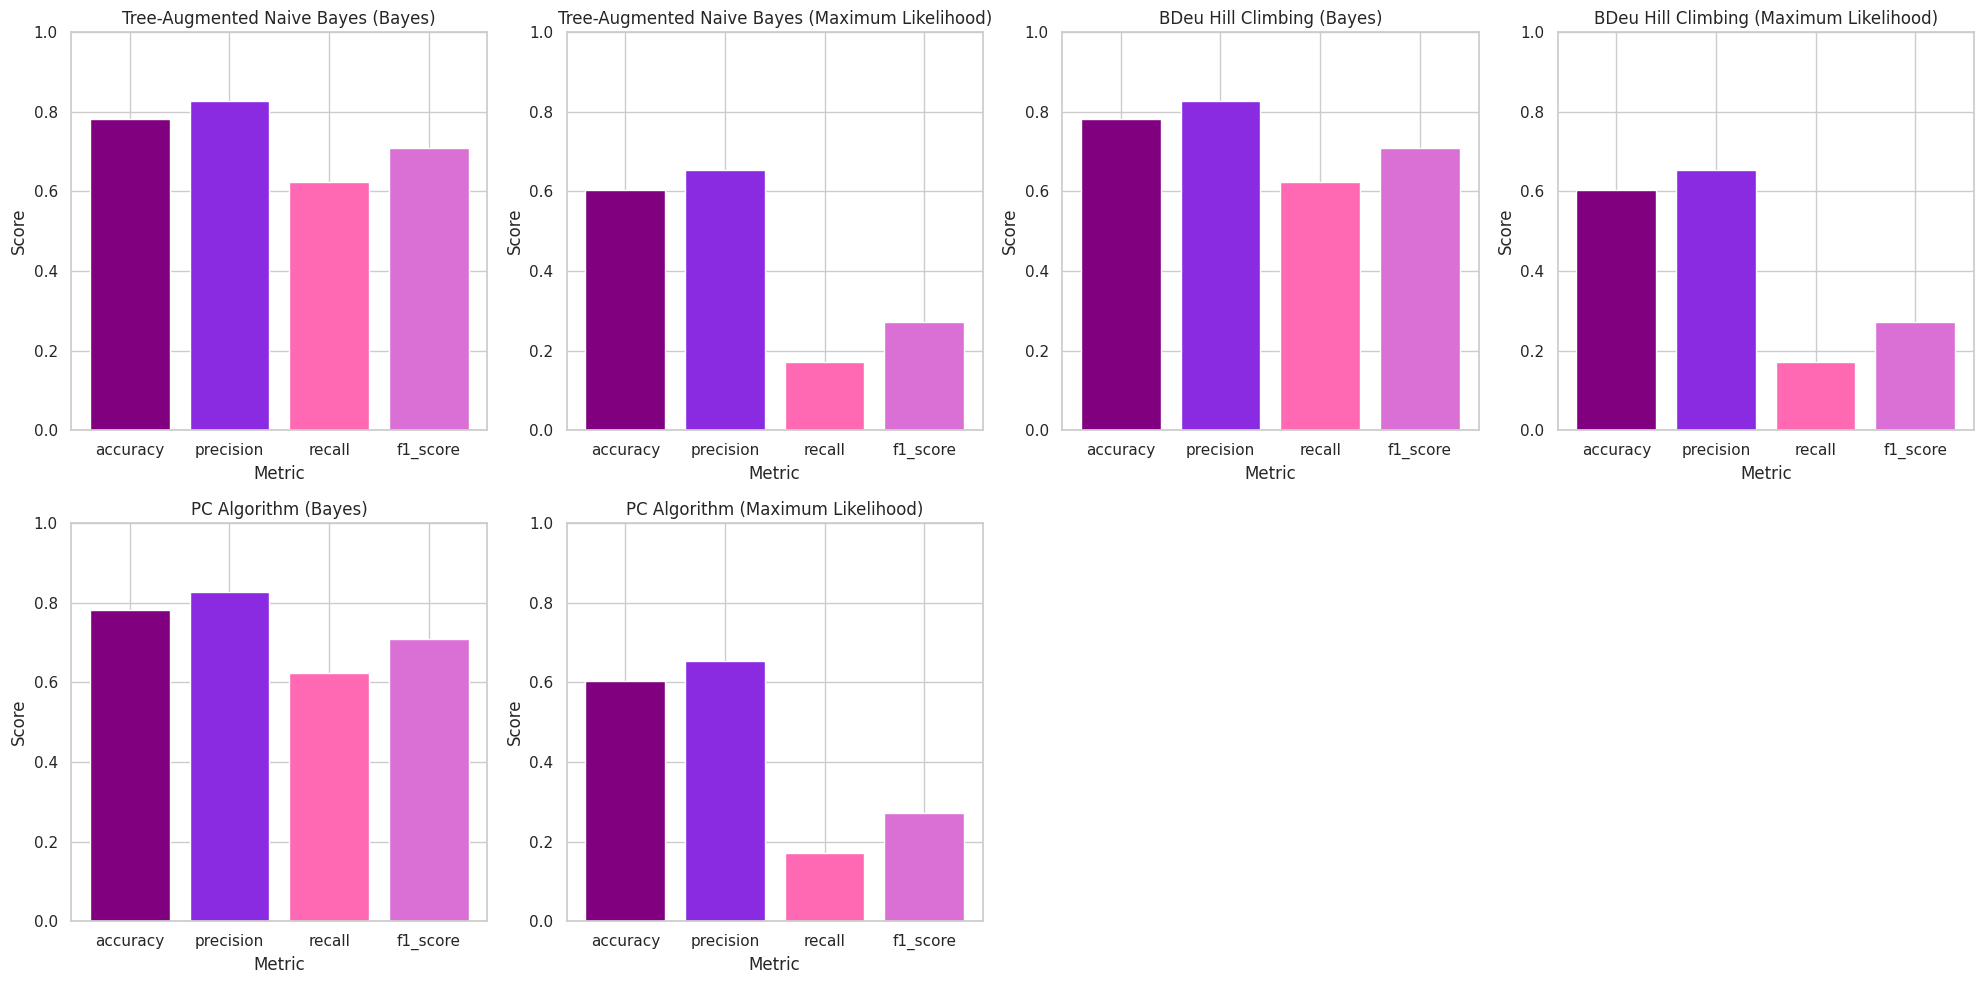

In [32]:
plot_metrics_graphs(metrics)

In [33]:
for method, metrictypes in metrics.items():
    print(f"\n{method}:")
    for metric, value in metrictypes.items():
        if metric in ['accuracy', 'precision', 'recall', 'f1_score']:
            print(f"  {metric.capitalize()}: {value * 100:.2f}%")
        else:
            print(f"  {metric.capitalize()}: {value}")


Tree-Augmented Naive Bayes (Bayes):
  Accuracy: 78.16%
  Precision: 82.72%
  Recall: 62.33%
  F1_score: 70.80%

Tree-Augmented Naive Bayes (Maximum Likelihood):
  Accuracy: 60.39%
  Precision: 65.43%
  Recall: 17.16%
  F1_score: 27.15%

BDeu Hill Climbing (Bayes):
  Accuracy: 78.16%
  Precision: 82.72%
  Recall: 62.33%
  F1_score: 70.80%

BDeu Hill Climbing (Maximum Likelihood):
  Accuracy: 60.39%
  Precision: 65.43%
  Recall: 17.16%
  F1_score: 27.15%

PC Algorithm (Bayes):
  Accuracy: 78.16%
  Precision: 82.72%
  Recall: 62.33%
  F1_score: 70.80%

PC Algorithm (Maximum Likelihood):
  Accuracy: 60.39%
  Precision: 65.43%
  Recall: 17.16%
  F1_score: 27.15%


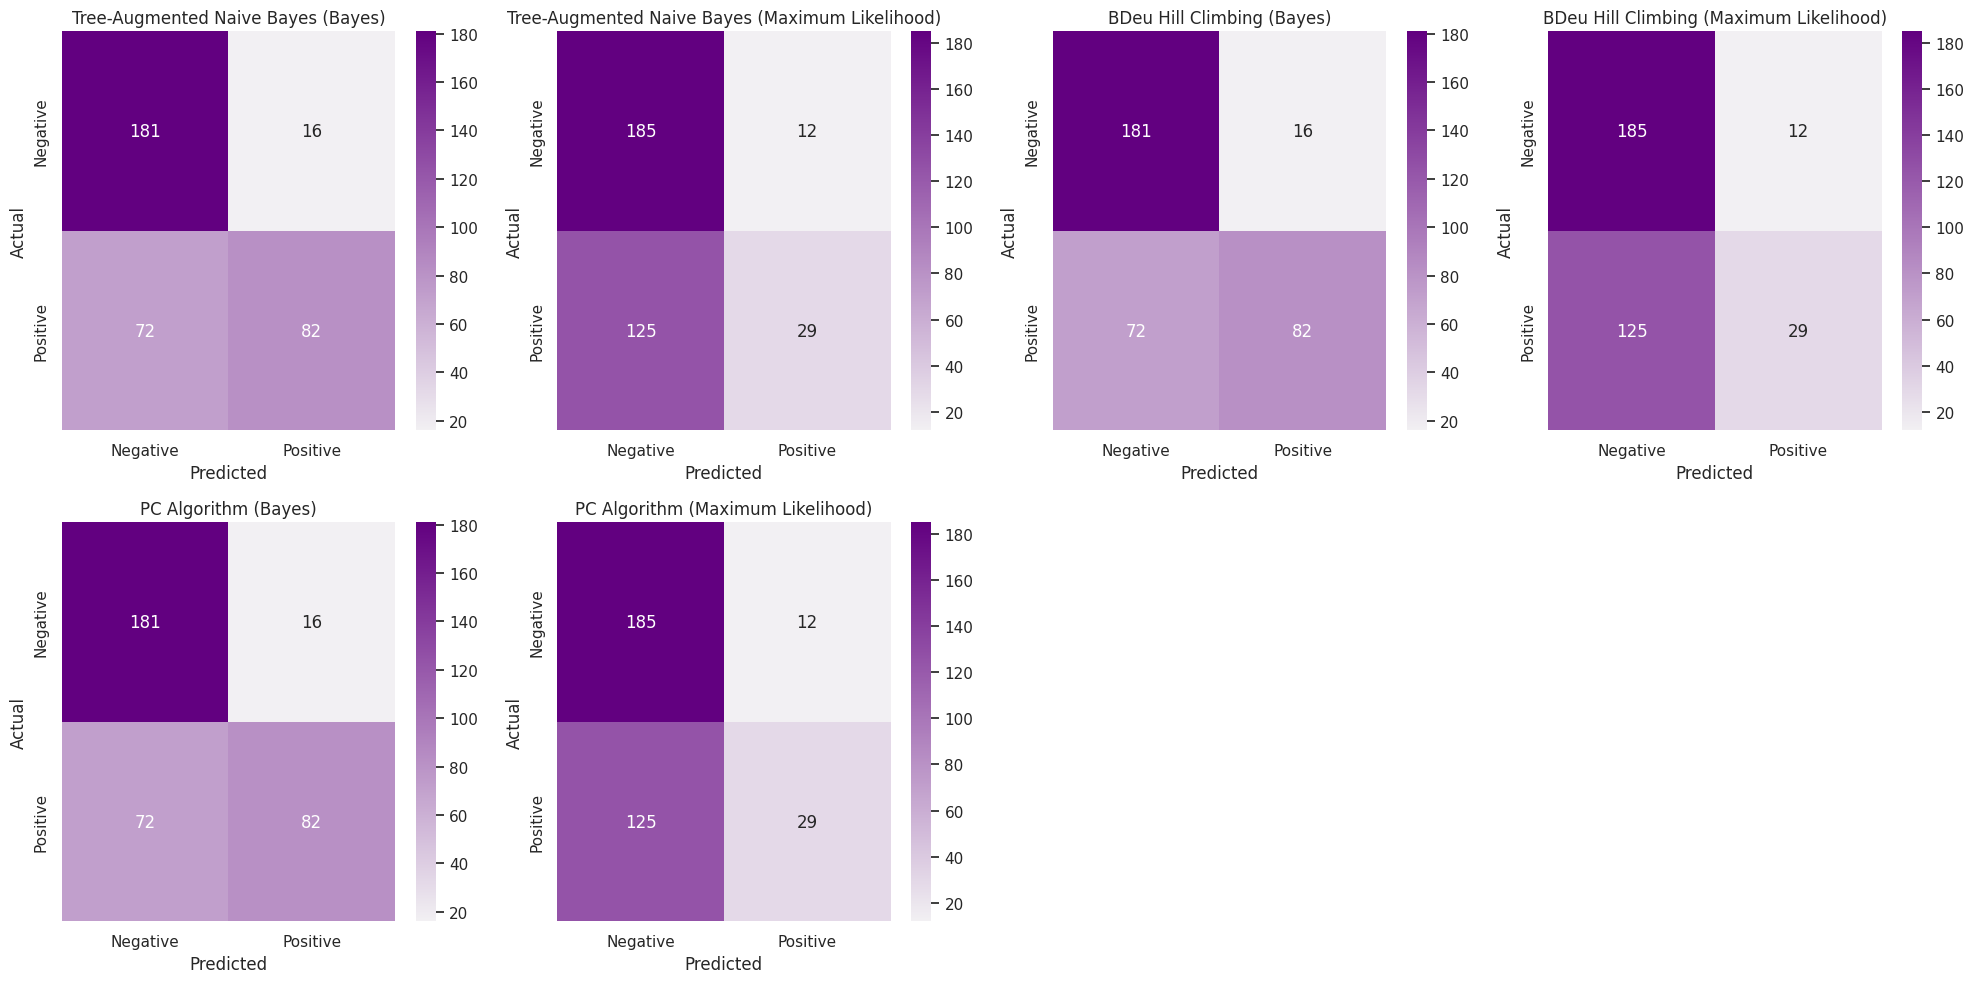

In [34]:
plot_confusion_matrices(confusion, cmap=gradient_palette)

# Parkinson's Disease
---

In [35]:
parkinsons_df = pd.read_csv('data/parkinsons_data_processed.csv')

## Discretising the Data
---

In [36]:
parkinsons_df_5bins = discretise(parkinsons_df.copy(), nbins=5)
parkinsons_df_sturges = discretise(parkinsons_df.copy(), method='sturges')
parkinsons_df_freedman_diaconis = discretise(parkinsons_df.copy(), method='freedman-diaconis')

### 5 Bin
---

In [37]:
parkinsons_df_5bins.head()

MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
0            0             0             0               0                 1   
1            0             0             1               1                 1   
2            0             0             1               1                 1   
3            0             0             1               1                 1   
4            0             0             1               1                 2   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
0         0         1           0             1                 1  ...   
1         0         1           0             2                 2  ...   
2         1         1           1             1                 1  ...   
3         1         1           1             2                 1  ...   
4         1         2           1             2                 2  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
0            1    0    2       1     1    4        2        2   1    2  
1            2    0    2       1     2    4        3        3   2    3  
2            2    0    2       1     2    4        3        3   2    2  
3            2    0    2       1     2    4        3        3   2    3  
4            2    0    2       1     1    4        3        2   2    3  

[5 rows x 23 columns]

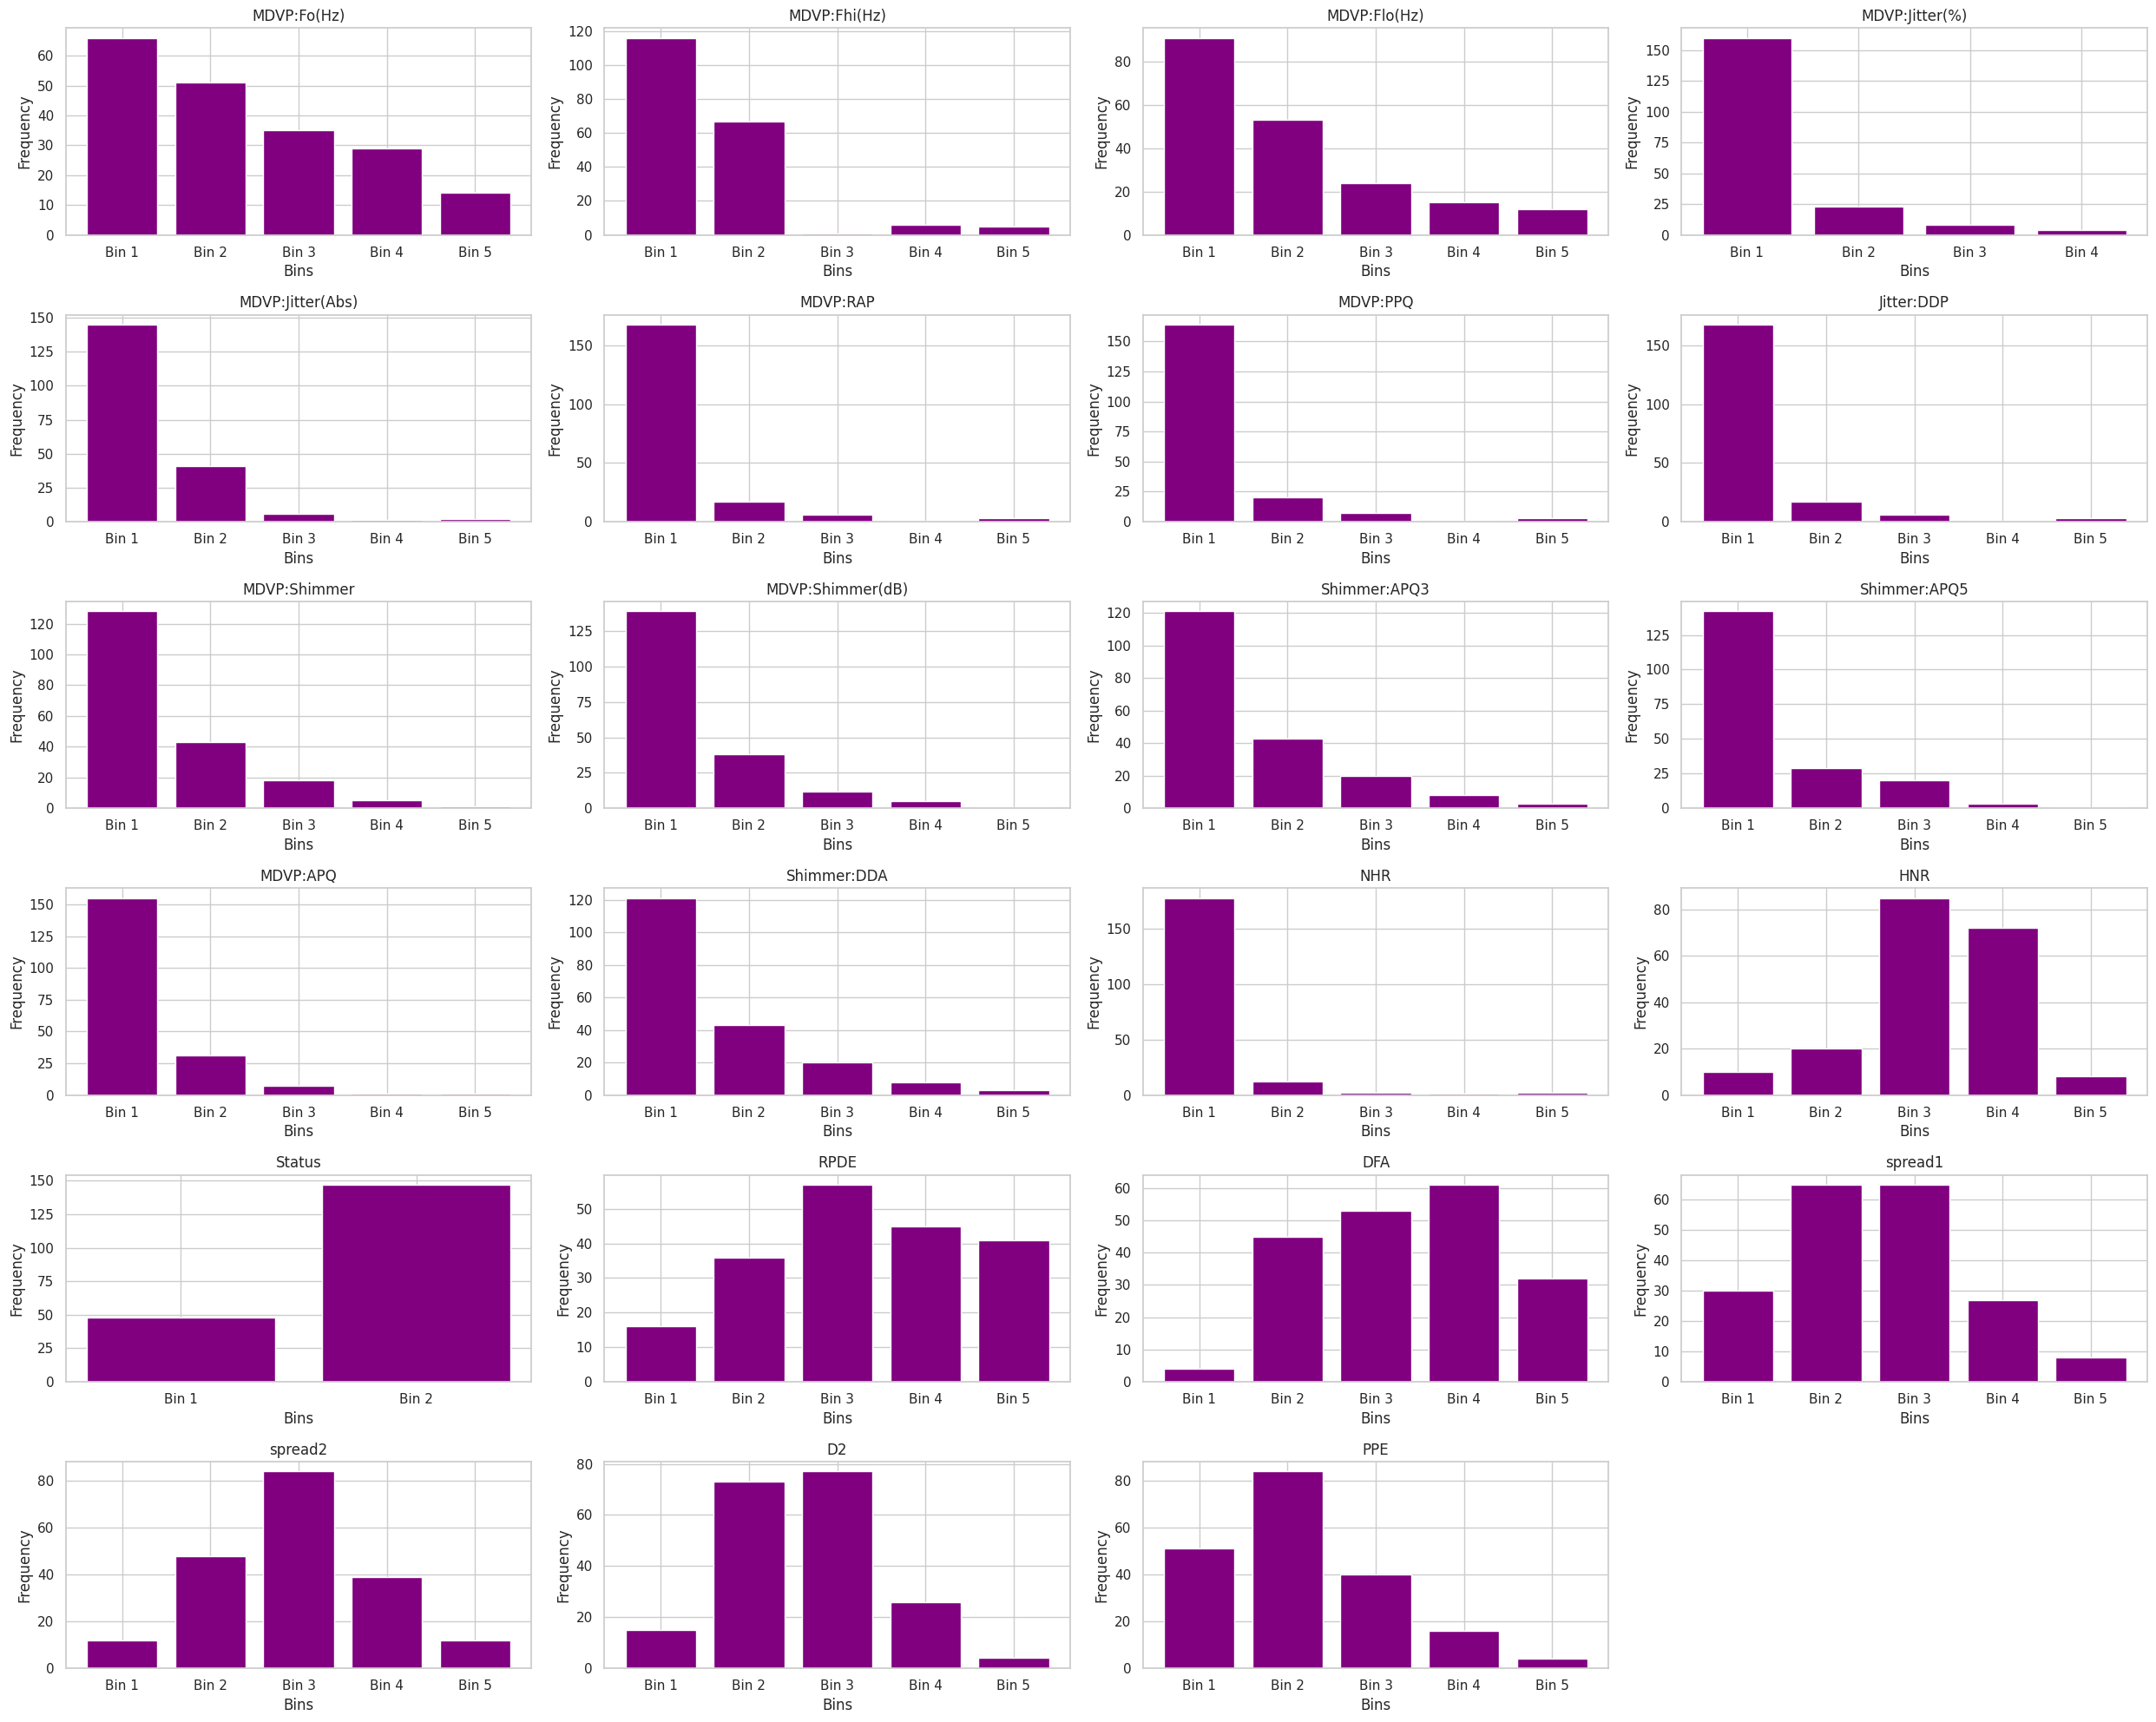

In [38]:
plot_bins_barcharts(parkinsons_df_5bins)

### Sturges
---

In [39]:
parkinsons_df_sturges.head()

MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
0            1             1             0               1                 2   
1            1             0             2               2                 2   
2            1             0             2               2                 2   
3            1             0             2               2                 2   
4            1             0             2               3                 3   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
0         1         2           1             2                 2  ...   
1         1         2           1             4                 4  ...   
2         2         3           2             3                 2  ...   
3         1         2           1             3                 3  ...   
4         2         3           2             4                 3  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
0            2    0    4       1     3    8        5        5   3    4  
1            4    0    3       1     4    8        6        6   4    6  
2            3    0    4       1     3    8        5        6   3    5  
3            4    0    4       1     3    8        6        6   3    6  
4            5    0    4       1     3    8        6        4   3    6  

[5 rows x 23 columns]

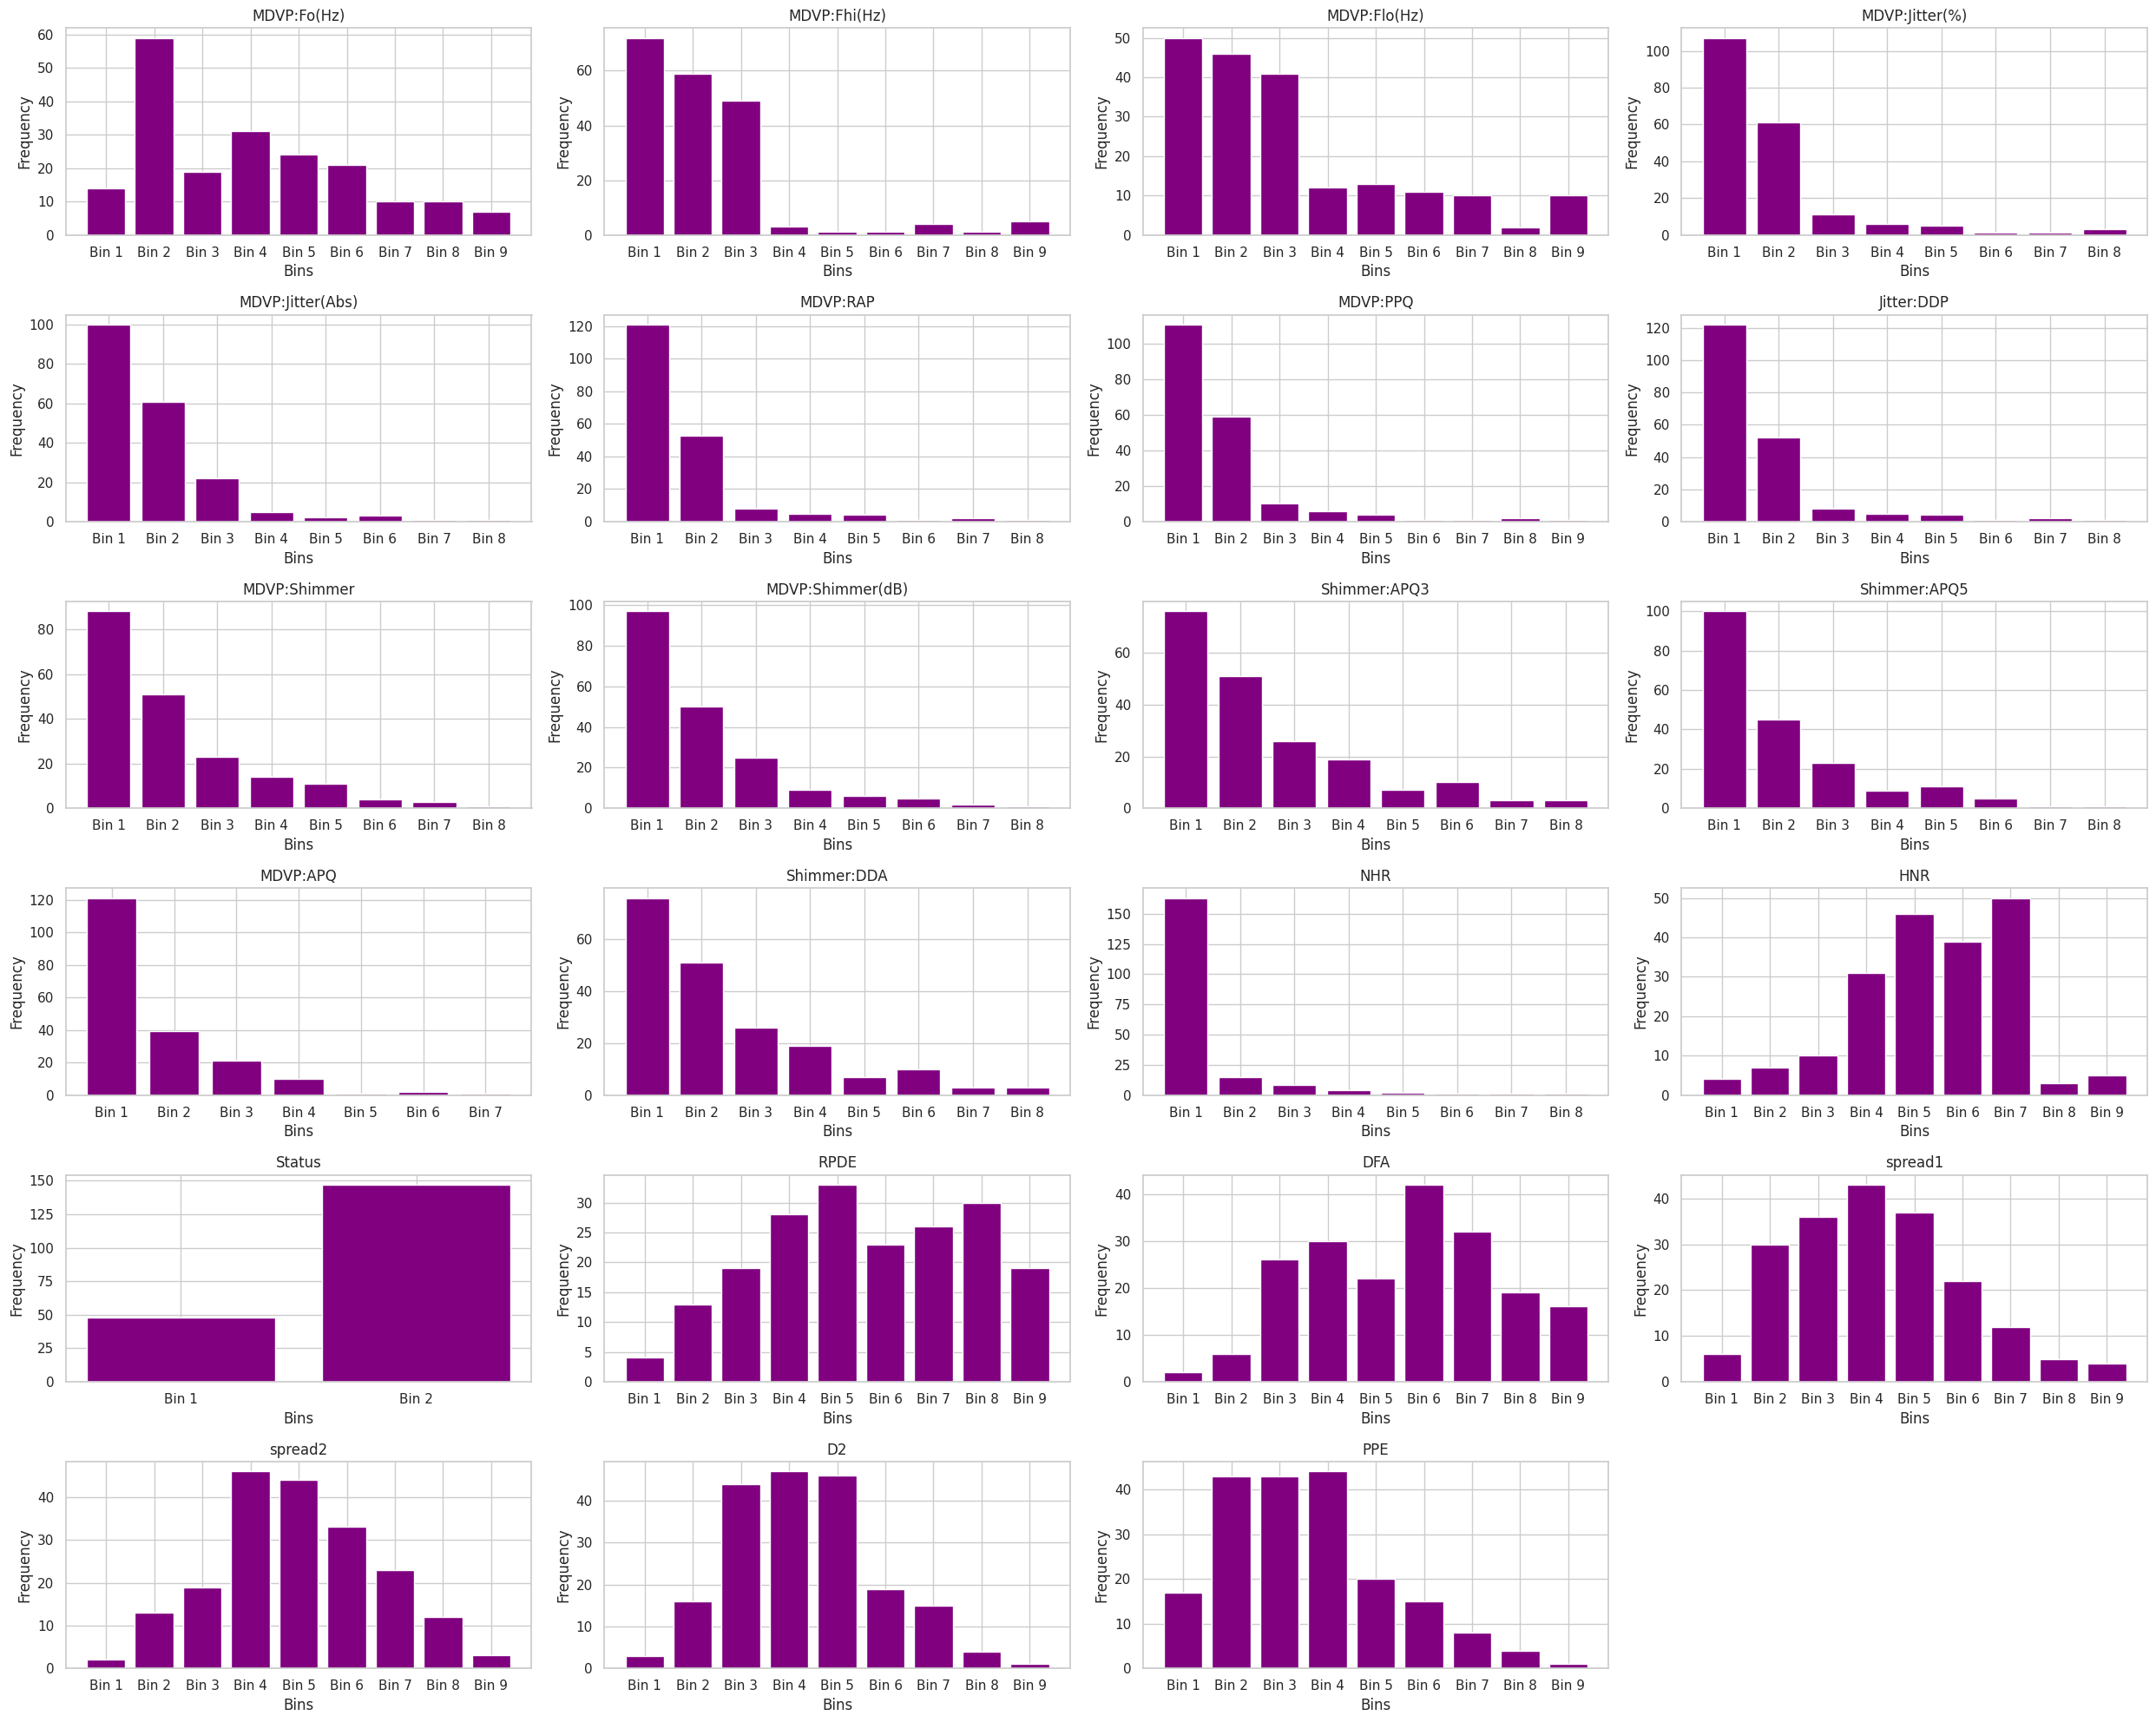

In [40]:
plot_bins_barcharts(parkinsons_df_sturges)

### Freedman Diaconis
---

In [41]:
parkinsons_df_freedman_diaconis.head()

MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
0            1             1             0               4                 4   
1            1             1             2               6                 5   
2            1             0             2               6                 6   
3            1             1             2               6                 6   
4            1             1             2               8                 7   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
0         4         6           4             4                 5  ...   
1         5         8           5             7                 8  ...   
2         6         9           6             5                 5  ...   
3         5         8           5             6                 6  ...   
4         7        11           7             7                 7  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
0            4    3    6       1     2    8        6        7   5    6  
1            6    2    5       1     3    8        8        9   6    8  
2            5    1    6       1     3    8        7        8   5    7  
3            6    1    6       1     3    8        8        9   5    8  
4            7    2    5       1     3    8        9        6   5    9  

[5 rows x 23 columns]

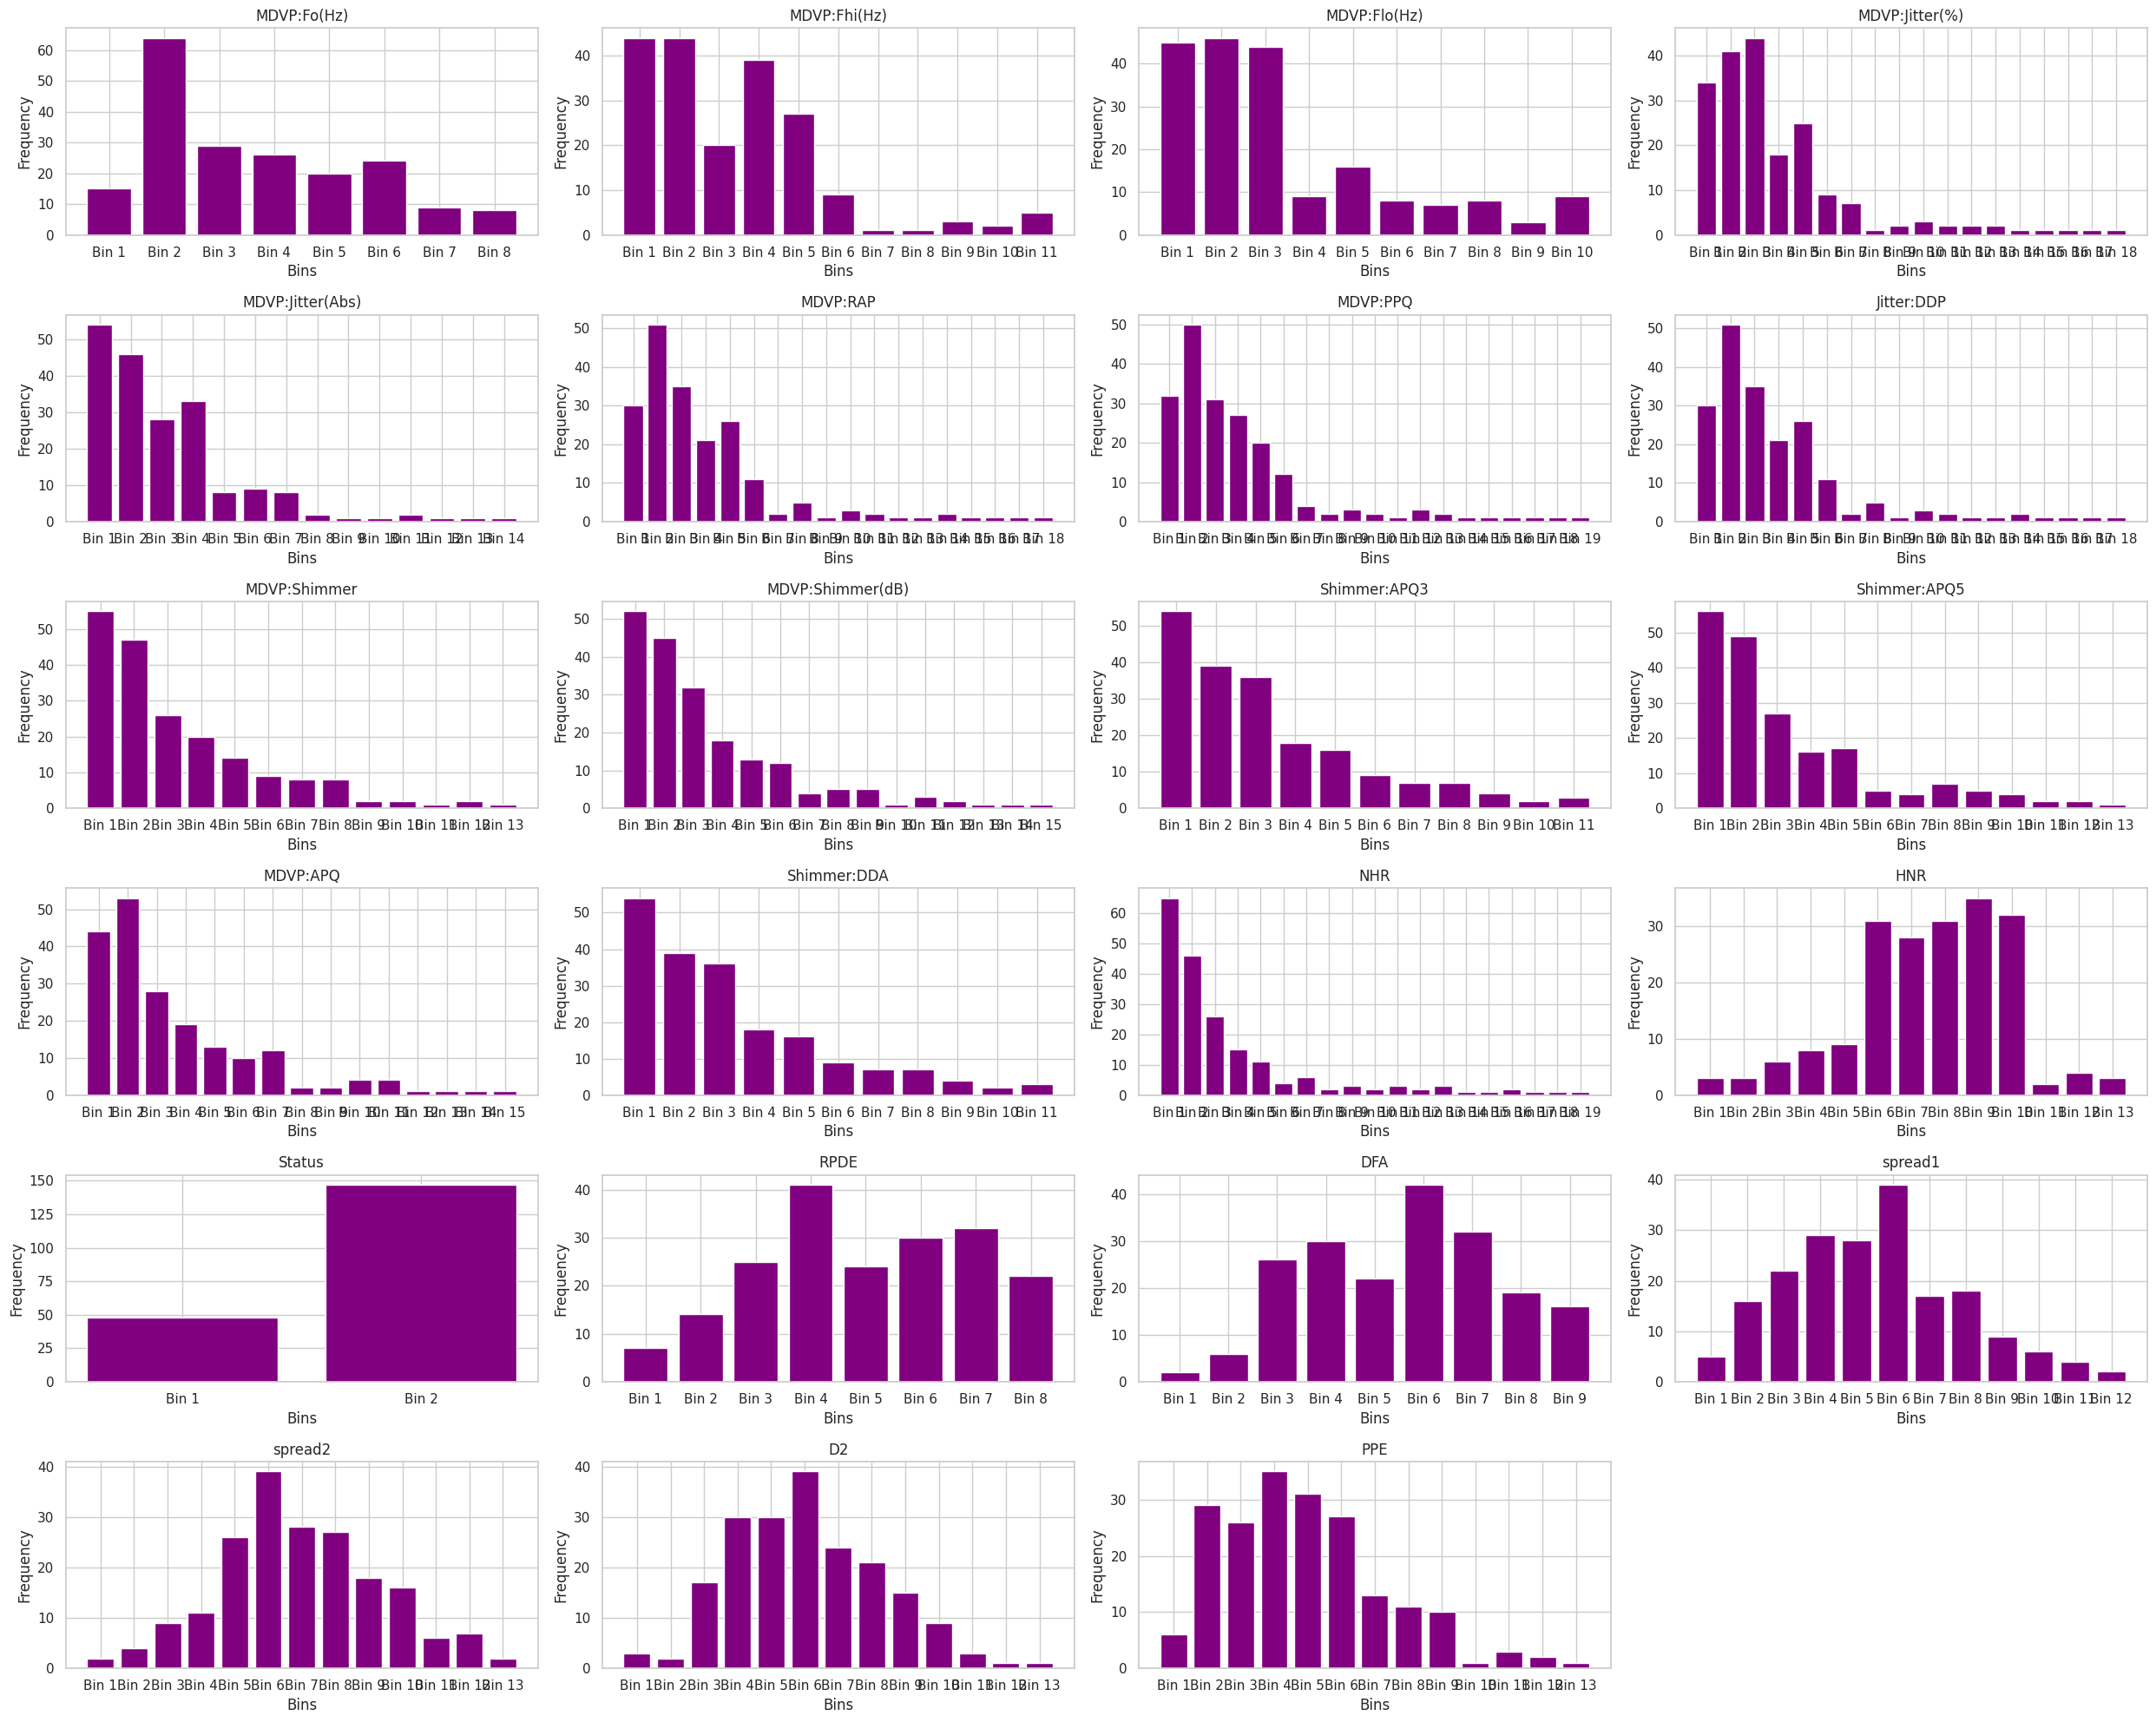

In [42]:
plot_bins_barcharts(parkinsons_df_freedman_diaconis)

### Comparing Discretisation Methods
---

In [43]:
mse_5bins = mean_squared_error(parkinsons_df, parkinsons_df_5bins)
mse_sturges = mean_squared_error(parkinsons_df, parkinsons_df_sturges)
mse_freedman_diaconis = mean_squared_error(parkinsons_df, parkinsons_df_freedman_diaconis)

In [44]:
mse_values = [mse_5bins, mse_sturges, mse_freedman_diaconis]

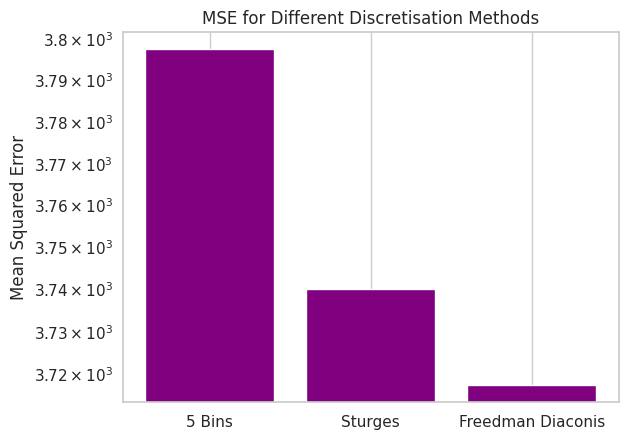

In [45]:
plt.bar(['5 Bins', 'Sturges', 'Freedman Diaconis'], mse_values)
plt.title('MSE for Different Discretisation Methods')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.show()

Again, we can see that Freedman Diaconis is the best method, but discrete data is still not great for this dataset either.

In [46]:
parkinsons_df = parkinsons_df_freedman_diaconis.copy()
dementia_df.describe().T

count       mean       std  min   25%   50%   75%   max
Group     364.0   0.439560  0.497017  0.0   0.0   0.0   1.0   1.0
Visit     364.0   0.868132  0.923627  0.0   0.0   1.0   1.0   4.0
MR Delay  364.0   2.151099  2.465570  0.0   0.0   2.0   3.0  10.0
M/F       364.0   0.574176  0.495148  0.0   0.0   1.0   1.0   1.0
Age       364.0   5.296703  2.559461  0.0   3.0   5.0   7.0  12.0
EDUC      364.0   5.653846  1.998887  0.0   4.0   5.0   7.0  11.0
SES       364.0   4.467033  3.325585  0.0   3.0   3.0   6.0  12.0
MMSE      364.0  16.414835  2.630799  0.0  16.0  18.0  18.0  18.0
CDR       364.0   0.137363  0.410375  0.0   0.0   0.0   0.0   3.0
eTIV      364.0   5.450549  2.791225  0.0   3.0   5.0   7.0  13.0
nWBV      364.0   5.285714  2.506348  0.0   3.0   5.0   7.0  12.0
ASF       364.0   5.771978  2.756447  0.0   4.0   6.0   8.0  13.0

## Learning Structure & Parameters with Cross-Validation
---

Now we will explore the process of structure learning and parameter learning for Bayesian Networks (BNs) using the provided dataset. We will evaluate multiple structure learning methods, perform parameter learning, and assess the results using cross-validation.

Our goals are:
1. To understand the structure of the data using various structure learning algorithms.
2. To learn the parameters of the best structure.
3. To evaluate the performance of each method through cross-validation.

The methods we will use:
1. Tree-Augmented Naive Bayes (TAN)
2. Hill Climbing (HC) with BDeu scoring
3. PC Algorithm

We will then evaluate each method's performance and compare the results.

### Cross-Validation
---

In [47]:
metrics = {}
confusion = {}

#### Tree-Augmented Naive Bayes
---

In [48]:
structure_kwargs_tan = {'methodtype': 'tan', 'class_node': 'Status'}

##### Bayes

In [49]:
metrics_tan_bayes, confusion_tan_bayes = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:RAP:
+--------------+----------------------+----------------------+
| Status       | Status(0)            | Status(1)            |
+--------------+----------------------+----------------------+
| MDVP:RAP(0)  | 0.07339073390733908  | 0.06315598986608757  |
+--------------+----------------------+----------------------+
| MDVP:RAP(1)  | 0.08630586305863058  | 0.08269996380745565  |
+--------------+----------------------+----------------------+
| MDVP:RAP(2)  | 0.05863058630586306  | 0.07781397032211364  |
+--------------+----------------------+----------------------+
| MDVP:RAP(3)  | 0.05678556785567856  | 0.0696706478465436   |
+--------------+----------------------+----------------------+
| MDVP:R

100%|██████████| 1/1 [00:00<00:00, 317.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.78it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 2 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
2            1             0             2               6                 6   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
2         6         9           6             5                 5  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
2            5    1    6       1     3    8        7        8   5    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.17it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 4 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
4            1             1             2               8                 7   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
4         7        11           7             7                 7  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
4            7    2    5       1     3    8        9        6   5    9  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 5 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
5            1             0             2               6                 5   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
5         5         9           5             5                 5  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
5            4    1    6       1     2    8        8        8   4    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 379.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.69it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 16 in fold 1: KeyError - 8
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
16            2             8             0               2                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
16         1         2           1             1                 1  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
16            1    2    7       1     5    2        5        6   4    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 244.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 251.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.27it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 32 in fold 1: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
32            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
32         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
32            0    0   11       0     3    5        1        4   0    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 33 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
33            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
33         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
33            0    0   12       0     2    6        0        5   0    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 34 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
34            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
34         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
34            0    0   12       0     1    6        0        4   0    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 35 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
35            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
35         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
35            0    0   12       0     1    6        0        4   5    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.43it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+----------------------+---------------------+
| Status       | Status(0)            | Status(1)           |
+--------------+----------------------+---------------------+
| MDVP:PPQ(0)  | 0.06474677259185697  | 0.06120733142761056 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(1)  | 0.06852035749751735  | 0.08996132503783422 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(2)  | 0.0609731876861966   | 0.07558432823272239 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(3)  | 0.05342601787487585  | 0.07877921641163613 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(4)  | 0.

100%|██████████| 1/1 [00:00<00:00, 250.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 228.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 399.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.94it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 63 in fold 2: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
63            6             4             9               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
63         1         0           1             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
63            1    0    9       0     0    3        1        0   6    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.56it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 65 in fold 2: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
65            6             4             2               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
65         0         0           0             1                 1  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
65            1    0    8       0     0    3        1        0   4    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.02it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 68 in fold 2: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
68            2             1             0               7                 5   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
68         7         5           7             6                 5  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
68            6    7    6       1     4    5        4        4   4    3  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 212.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 227.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 248.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.84it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+----------------------+---------------------+
| Status       | Status(0)            | Status(1)           |
+--------------+----------------------+---------------------+
| MDVP:PPQ(0)  | 0.09169708029197081  | 0.06291118421052631 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(1)  | 0.08804744525547445  | 0.09416118421052631 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(2)  | 0.06797445255474452  | 0.08264802631578948 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(3)  | 0.06067518248175183  | 0.08264802631578948 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(4)  | 0.

100%|██████████| 1/1 [00:00<00:00, 285.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 242.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.56it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 87 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
87            4             4             3               2                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
87         2         3           2             7                 7  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
87            8    7    2       1     6    5        5        8   9    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 88 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
88            3             3             0               2                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
88         2         2           2             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
88            8    6    3       1     6    6        4        8   9    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 89 in fold 3: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
89            4             4             4               4                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
89         4         4           4             4                 5  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
89            4   10    1       1     6    6        7       10  12    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 90 in fold 3: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
90            3             3             0               4                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
90         4         5           4             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
90            7   12    1       1     7    5        7       11  10    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 91 in fold 3: KeyError - 10
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
91            2             1             4               1                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
91         2         1           2             9                10  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
91            9    2    5       1     4    5        3        5   5    2  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 221.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 251.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.57it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
97            1             1             2               8                 6   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
97         9         7           9             4                 3  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
97            4   12    3       1     6    5        8        7   7    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 98 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
98            1             1             1               9                 7   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
98        10         7          10             5                 4  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
98            5   15    3       1     5    4        6        5   5    5  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 99 in fold 3: KeyError - 13
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
99            1             1             1              13                10   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
99        14        12          14             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
99            7   24    2       1     7    3        9        6   7    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 100 in fold 3: KeyError - 19
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
100            1             1             2              23   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
100                18        27        19          27            11   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
100                11  ...           12   46    0       1     7    2        9   

     spread2  D2  PPE  
100        7   9    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 101 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
101            1             1             0              10   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
101                 8        11        11          11             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
101                 7  ...            6   17    3       1     7    2        8   

     spread2  D2  PPE  
101        8   7    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 102 in fold 3: KeyError - 21
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
102            2            15             0              21   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
102                15        24        21          24            11   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
102                12  ...           12   38    1       1     6    2       10   

     spread2  D2  PPE  
102        7   7   10  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 417.18it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 3: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
104            3             1             3               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
104                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
104                 0  ...            0    0   10       1     0    4        1   

     spread2  D2  PPE  
104        4   3    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 3: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
105            2             1             3               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
105                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
105                 0  ...            0    0   10       1     2    5        2   

     spread2  D2  PPE  
105        5   3    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 398.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 423.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 388.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.87it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+---------------------+----------------------+
| Status       | Status(0)           | Status(1)            |
+--------------+---------------------+----------------------+
| MDVP:PPQ(0)  | 0.09984358706986445 | 0.07518796992481204  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(1)  | 0.0961939520333681  | 0.09656954887218047  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(2)  | 0.07612095933263817 | 0.08834586466165416  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(3)  | 0.06882168925964546 | 0.08834586466165416  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(4)  | 0.

100%|██████████| 1/1 [00:00<00:00, 379.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 371.64it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 4: KeyError - 0
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            5             4             1               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
119                 0  ...            0    0    8       1     3    0        5   

     spread2  D2  PPE  
119       11   8    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 242.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 227.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 240.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 391.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 239.37it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 145 in fold 4: KeyError - 0
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
145            6             5             1               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
145                 0         1         1           1             2   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
145                 2  ...            2    2    6       1     5    0        5   

     spread2  D2  PPE  
145        9   8    5  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 146 in fold 4: KeyError - 11
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
146            3             2             4              10   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
146                 6        10        11          10             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
146                10  ...            8   11    2       1     5    7       10   

     spread2  D2  PPE  
146       11  11   11  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 147 in fold 4: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
147            4             3             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
147                 5        10        10          10             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
147                 7  ...            6    8    3       1     4    6        8   

     spread2  D2  PPE  
147       10   9    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 148 in fold 4: KeyError - 13
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
148            4             3             5              11   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
148                 6        12        13          12             8   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
148                 9  ...            7   11    2       1     5    6        9   

     spread2  D2  PPE  
148        9  10   10  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 149 in fold 4: KeyError - 11
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
149            5            15             6              11   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
149                 5        11        12          11             8   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
149                11  ...            7   11    3       1     3    7        6   

     spread2  D2  PPE  
149        7   8    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 4: KeyError - 14
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            4             3             4              12   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 6        13        14          13             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
150                10  ...            5   16    2       1     4    6        7   

     spread2  D2  PPE  
150        9   8    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 151 in fold 4: KeyError - 25
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
151            4             3             5              22   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
151                11        23        25          23            14   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
151                17  ...           12   32    0       1     6    6       11   

     spread2  D2  PPE  
151       12   9   12  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 152 in fold 4: KeyError - 22
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
152            5             4             6              19   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
152                 9        20        22          20            10   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
152                13  ...            9   24    0       1     6    6       11   

     spread2  D2  PPE  
152       10  10   11  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.67it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+---------------------+----------------------+
| Status       | Status(0)           | Status(1)            |
+--------------+---------------------+----------------------+
| MDVP:PPQ(0)  | 0.08075532342306144 | 0.060626249167221855 |
+--------------+---------------------+----------------------+
| MDVP:PPQ(1)  | 0.06548814785054237 | 0.0859427048634244   |
+--------------+---------------------+----------------------+
| MDVP:PPQ(2)  | 0.05022097227802329 | 0.07961359093937376  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(3)  | 0.05022097227802329 | 0.07328447701532312  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(4)  | 0.

100%|██████████| 1/1 [00:00<00:00, 260.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 429.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 399.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 241.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 209.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 240.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 235.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.69it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 193 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
193            5             9             0               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
193                 2         4         4           4             1   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
193                 2  ...            2   10    5       0     3    2        2   

     spread2  D2  PPE  
193        5   4    2  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Shimmer(dB)', 'PPE', 'MDVP:Jitter(Abs)', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:APQ', 'spread1', 'MDVP:Fo(Hz)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'HNR', 'DFA', 'NHR', 'RPDE', 'D2', 'spread2', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.10it/s]


In [50]:
metrics['Tree-Augmented Naive Bayes (Bayes)'] = metrics_tan_bayes
confusion['Tree-Augmented Naive Bayes (Bayes)'] = confusion_tan_bayes

##### Maximum Likelihood

In [51]:
metrics_tan_ml, confusion_tan_ml = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:RAP:
+--------------+----------------------+----------------------+
| Status       | Status(0)            | Status(1)            |
+--------------+----------------------+----------------------+
| MDVP:RAP(0)  | 0.2857142857142857   | 0.09649122807017543  |
+--------------+----------------------+----------------------+
| MDVP:RAP(1)  | 0.4523809523809524   | 0.20175438596491227  |
+--------------+----------------------+----------------------+
| MDVP:RAP(2)  | 0.09523809523809523  | 0.17543859649122806  |
+--------------+----------------------+----------------------+
| MDVP:RAP(3)  | 0.07142857142857142  | 0.13157894736842105  |
+--------------+----------------------+----------------------+
| MDVP:RAP(

100%|██████████| 1/1 [00:00<00:00, 341.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.70it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 2 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
2            1             0             2               6                 6   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
2         6         9           6             5                 5  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
2            5    1    6       1     3    8        7        8   5    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 406.66it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 4 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
4            1             1             2               8                 7   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
4         7        11           7             7                 7  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
4            7    2    5       1     3    8        9        6   5    9  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 5 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
5            1             0             2               6                 5   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
5         5         9           5             5                 5  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
5            4    1    6       1     2    8        8        8   4    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 387.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 403.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 248.05it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 16 in fold 1: KeyError - 8
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
16            2             8             0               2                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
16         1         2           1             1                 1  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
16            1    2    7       1     5    2        5        6   4    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 240.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 229.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.83it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 32 in fold 1: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
32            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
32         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
32            0    0   11       0     3    5        1        4   0    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 33 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
33            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
33         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
33            0    0   12       0     2    6        0        5   0    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 34 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
34            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
34         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
34            0    0   12       0     1    6        0        4   0    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 35 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
35            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
35         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
35            0    0   12       0     1    6        0        4   5    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 418.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.30it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+---------------------+----------------------+
| Status       | Status(0)           | Status(1)            |
+--------------+---------------------+----------------------+
| MDVP:PPQ(0)  | 0.26666666666666666 | 0.09523809523809523  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(1)  | 0.3333333333333333  | 0.23809523809523808  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(2)  | 0.2                 | 0.16666666666666666  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(3)  | 0.06666666666666667 | 0.18253968253968253  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(4)  | 0.1  

100%|██████████| 1/1 [00:00<00:00, 356.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 194.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 209.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 255.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.79it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 63 in fold 2: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
63            6             4             9               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
63         1         0           1             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
63            1    0    9       0     0    3        1        0   6    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.42it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 65 in fold 2: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
65            6             4             2               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
65         0         0           0             1                 1  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
65            1    0    8       0     0    3        1        0   4    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 436.63it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 68 in fold 2: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
68            2             1             0               7                 5   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
68         7         5           7             6                 5  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
68            6    7    6       1     4    5        4        4   4    3  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 387.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.46it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+----------------------+----------------------+
| Status       | Status(0)            | Status(1)            |
+--------------+----------------------+----------------------+
| MDVP:PPQ(0)  | 0.3958333333333333   | 0.06481481481481481  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(1)  | 0.3541666666666667   | 0.24074074074074073  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(2)  | 0.125                | 0.17592592592592593  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(3)  | 0.041666666666666664 | 0.17592592592592593  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(

100%|██████████| 1/1 [00:00<00:00, 376.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.09it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 87 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
87            4             4             3               2                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
87         2         3           2             7                 7  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
87            8    7    2       1     6    5        5        8   9    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 88 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
88            3             3             0               2                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
88         2         2           2             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
88            8    6    3       1     6    6        4        8   9    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 89 in fold 3: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
89            4             4             4               4                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
89         4         4           4             4                 5  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
89            4   10    1       1     6    6        7       10  12    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 90 in fold 3: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
90            3             3             0               4                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
90         4         5           4             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
90            7   12    1       1     7    5        7       11  10    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 91 in fold 3: KeyError - 10
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
91            2             1             4               1                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
91         2         1           2             9                10  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
91            9    2    5       1     4    5        3        5   5    2  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.95it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
97            1             1             2               8                 6   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
97         9         7           9             4                 3  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
97            4   12    3       1     6    5        8        7   7    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 98 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
98            1             1             1               9                 7   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
98        10         7          10             5                 4  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
98            5   15    3       1     5    4        6        5   5    5  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 99 in fold 3: KeyError - 13
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
99            1             1             1              13                10   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
99        14        12          14             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
99            7   24    2       1     7    3        9        6   7    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 100 in fold 3: KeyError - 19
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
100            1             1             2              23   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
100                18        27        19          27            11   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
100                11  ...           12   46    0       1     7    2        9   

     spread2  D2  PPE  
100        7   9    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 101 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
101            1             1             0              10   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
101                 8        11        11          11             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
101                 7  ...            6   17    3       1     7    2        8   

     spread2  D2  PPE  
101        8   7    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 102 in fold 3: KeyError - 21
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
102            2            15             0              21   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
102                15        24        21          24            11   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
102                12  ...           12   38    1       1     6    2       10   

     spread2  D2  PPE  
102        7   7   10  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 238.33it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]

Error for row 104 in fold 3: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
104            3             1             3               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
104                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
104                 0  ...            0    0   10       1     0    4        1   

     spread2  D2  PPE  
104        4   3    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22



  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 3: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
105            2             1             3               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
105                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
105                 0  ...            0    0   10       1     2    5        2   

     spread2  D2  PPE  
105        5   3    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 224.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 249.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 226.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.53it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+----------------------+----------------------+
| Status       | Status(0)            | Status(1)            |
+--------------+----------------------+----------------------+
| MDVP:PPQ(0)  | 0.3958333333333333   | 0.09259259259259259  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(1)  | 0.3541666666666667   | 0.21296296296296297  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(2)  | 0.125                | 0.16666666666666666  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(3)  | 0.041666666666666664 | 0.16666666666666666  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(

100%|██████████| 1/1 [00:00<00:00, 319.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.11it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 4: KeyError - 0
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            5             4             1               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
119                 0  ...            0    0    8       1     3    0        5   

     spread2  D2  PPE  
119       11   8    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 402.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 234.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 241.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 244.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 219.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 379.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.92it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 145 in fold 4: KeyError - 0
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
145            6             5             1               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
145                 0         1         1           1             2   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
145                 2  ...            2    2    6       1     5    0        5   

     spread2  D2  PPE  
145        9   8    5  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 146 in fold 4: KeyError - 11
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
146            3             2             4              10   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
146                 6        10        11          10             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
146                10  ...            8   11    2       1     5    7       10   

     spread2  D2  PPE  
146       11  11   11  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 147 in fold 4: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
147            4             3             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
147                 5        10        10          10             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
147                 7  ...            6    8    3       1     4    6        8   

     spread2  D2  PPE  
147       10   9    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 148 in fold 4: KeyError - 13
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
148            4             3             5              11   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
148                 6        12        13          12             8   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
148                 9  ...            7   11    2       1     5    6        9   

     spread2  D2  PPE  
148        9  10   10  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 149 in fold 4: KeyError - 11
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
149            5            15             6              11   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
149                 5        11        12          11             8   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
149                11  ...            7   11    3       1     3    7        6   

     spread2  D2  PPE  
149        7   8    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 4: KeyError - 14
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            4             3             4              12   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 6        13        14          13             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
150                10  ...            5   16    2       1     4    6        7   

     spread2  D2  PPE  
150        9   8    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 151 in fold 4: KeyError - 25
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
151            4             3             5              22   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
151                11        23        25          23            14   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
151                17  ...           12   32    0       1     6    6       11   

     spread2  D2  PPE  
151       12   9   12  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 152 in fold 4: KeyError - 22
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
152            5             4             6              19   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
152                 9        20        22          20            10   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
152                13  ...            9   24    0       1     6    6       11   

     spread2  D2  PPE  
152       10  10   11  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 408.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.70it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+--------------------+----------------------+
| Status       | Status(0)          | Status(1)            |
+--------------+--------------------+----------------------+
| MDVP:PPQ(0)  | 0.6666666666666666 | 0.09090909090909091  |
+--------------+--------------------+----------------------+
| MDVP:PPQ(1)  | 0.3333333333333333 | 0.21212121212121213  |
+--------------+--------------------+----------------------+
| MDVP:PPQ(2)  | 0.0                | 0.18181818181818182  |
+--------------+--------------------+----------------------+
| MDVP:PPQ(3)  | 0.0                | 0.15151515151515152  |
+--------------+--------------------+----------------------+
| MDVP:PPQ(4)  | 0.0             

100%|██████████| 1/1 [00:00<00:00, 352.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 251.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 409.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 407.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 409.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 232.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 182.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 406.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 219.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.23it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 193 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
193            5             9             0               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
193                 2         4         4           4             1   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
193                 2  ...            2   10    5       0     3    2        2   

     spread2  D2  PPE  
193        5   4    2  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Shimmer(dB)', 'PPE', 'MDVP:Jitter(Abs)', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:APQ', 'spread1', 'MDVP:Fo(Hz)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'HNR', 'DFA', 'NHR', 'RPDE', 'D2', 'spread2', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.57it/s]


In [52]:
metrics['Tree-Augmented Naive Bayes (Maximum Likelihood)'] = metrics_tan_ml
confusion['Tree-Augmented Naive Bayes (Maximum Likelihood)'] = confusion_tan_ml


#### Hill Climbing
---

In [53]:
structure_kwargs_hc = {'methodtype': 'hc', 'scoretype': 'bdeu'}

##### Bayes

In [54]:
metrics_hc_bayes, confusion_hc_bayes = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:RAP:
+--------------+----------------------+----------------------+
| Status       | Status(0)            | Status(1)            |
+--------------+----------------------+----------------------+
| MDVP:RAP(0)  | 0.07339073390733908  | 0.06315598986608757  |
+--------------+----------------------+----------------------+
| MDVP:RAP(1)  | 0.08630586305863058  | 0.08269996380745565  |
+--------------+----------------------+----------------------+
| MDVP:RAP(2)  | 0.05863058630586306  | 0.07781397032211364  |
+--------------+----------------------+----------------------+
| MDVP:RAP(3)  | 0.05678556785567856  | 0.0696706478465436   |
+--------------+----------------------+----------------------+
| MDVP:R

100%|██████████| 1/1 [00:00<00:00, 305.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.99it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 2 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
2            1             0             2               6                 6   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
2         6         9           6             5                 5  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
2            5    1    6       1     3    8        7        8   5    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.54it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 4 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
4            1             1             2               8                 7   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
4         7        11           7             7                 7  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
4            7    2    5       1     3    8        9        6   5    9  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 5 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
5            1             0             2               6                 5   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
5         5         9           5             5                 5  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
5            4    1    6       1     2    8        8        8   4    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.51it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 16 in fold 1: KeyError - 8
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
16            2             8             0               2                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
16         1         2           1             1                 1  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
16            1    2    7       1     5    2        5        6   4    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.87it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 32 in fold 1: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
32            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
32         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
32            0    0   11       0     3    5        1        4   0    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 33 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
33            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
33         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
33            0    0   12       0     2    6        0        5   0    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 34 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
34            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
34         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
34            0    0   12       0     1    6        0        4   0    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 35 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
35            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
35         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
35            0    0   12       0     1    6        0        4   5    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 248.99it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+----------------------+---------------------+
| Status       | Status(0)            | Status(1)           |
+--------------+----------------------+---------------------+
| MDVP:PPQ(0)  | 0.06474677259185697  | 0.06120733142761056 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(1)  | 0.06852035749751735  | 0.08996132503783422 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(2)  | 0.0609731876861966   | 0.07558432823272239 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(3)  | 0.05342601787487585  | 0.07877921641163613 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(4)  | 0.

100%|██████████| 1/1 [00:00<00:00, 367.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.40it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 63 in fold 2: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
63            6             4             9               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
63         1         0           1             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
63            1    0    9       0     0    3        1        0   6    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 401.56it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 65 in fold 2: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
65            6             4             2               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
65         0         0           0             1                 1  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
65            1    0    8       0     0    3        1        0   4    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.08it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 68 in fold 2: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
68            2             1             0               7                 5   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
68         7         5           7             6                 5  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
68            6    7    6       1     4    5        4        4   4    3  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 220.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 233.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 394.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.85it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+----------------------+---------------------+
| Status       | Status(0)            | Status(1)           |
+--------------+----------------------+---------------------+
| MDVP:PPQ(0)  | 0.09169708029197081  | 0.06291118421052631 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(1)  | 0.08804744525547445  | 0.09416118421052631 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(2)  | 0.06797445255474452  | 0.08264802631578948 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(3)  | 0.06067518248175183  | 0.08264802631578948 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(4)  | 0.

100%|██████████| 1/1 [00:00<00:00, 259.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 418.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.69it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 87 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
87            4             4             3               2                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
87         2         3           2             7                 7  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
87            8    7    2       1     6    5        5        8   9    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 88 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
88            3             3             0               2                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
88         2         2           2             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
88            8    6    3       1     6    6        4        8   9    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 89 in fold 3: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
89            4             4             4               4                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
89         4         4           4             4                 5  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
89            4   10    1       1     6    6        7       10  12    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 90 in fold 3: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
90            3             3             0               4                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
90         4         5           4             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
90            7   12    1       1     7    5        7       11  10    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 91 in fold 3: KeyError - 10
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
91            2             1             4               1                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
91         2         1           2             9                10  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
91            9    2    5       1     4    5        3        5   5    2  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.16it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
97            1             1             2               8                 6   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
97         9         7           9             4                 3  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
97            4   12    3       1     6    5        8        7   7    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 98 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
98            1             1             1               9                 7   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
98        10         7          10             5                 4  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
98            5   15    3       1     5    4        6        5   5    5  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 99 in fold 3: KeyError - 13
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
99            1             1             1              13                10   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
99        14        12          14             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
99            7   24    2       1     7    3        9        6   7    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 100 in fold 3: KeyError - 19
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
100            1             1             2              23   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
100                18        27        19          27            11   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
100                11  ...           12   46    0       1     7    2        9   

     spread2  D2  PPE  
100        7   9    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 101 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
101            1             1             0              10   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
101                 8        11        11          11             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
101                 7  ...            6   17    3       1     7    2        8   

     spread2  D2  PPE  
101        8   7    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 102 in fold 3: KeyError - 21
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
102            2            15             0              21   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
102                15        24        21          24            11   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
102                12  ...           12   38    1       1     6    2       10   

     spread2  D2  PPE  
102        7   7   10  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.09it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 3: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
104            3             1             3               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
104                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
104                 0  ...            0    0   10       1     0    4        1   

     spread2  D2  PPE  
104        4   3    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 3: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
105            2             1             3               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
105                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
105                 0  ...            0    0   10       1     2    5        2   

     spread2  D2  PPE  
105        5   3    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 379.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 391.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.43it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+---------------------+----------------------+
| Status       | Status(0)           | Status(1)            |
+--------------+---------------------+----------------------+
| MDVP:PPQ(0)  | 0.09984358706986445 | 0.07518796992481204  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(1)  | 0.0961939520333681  | 0.09656954887218047  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(2)  | 0.07612095933263817 | 0.08834586466165416  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(3)  | 0.06882168925964546 | 0.08834586466165416  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(4)  | 0.

100%|██████████| 1/1 [00:00<00:00, 217.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.61it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 4: KeyError - 0
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            5             4             1               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
119                 0  ...            0    0    8       1     3    0        5   

     spread2  D2  PPE  
119       11   8    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 423.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 429.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 207.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 247.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 229.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 385.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.44it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 145 in fold 4: KeyError - 0
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
145            6             5             1               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
145                 0         1         1           1             2   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
145                 2  ...            2    2    6       1     5    0        5   

     spread2  D2  PPE  
145        9   8    5  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 146 in fold 4: KeyError - 11
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
146            3             2             4              10   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
146                 6        10        11          10             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
146                10  ...            8   11    2       1     5    7       10   

     spread2  D2  PPE  
146       11  11   11  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 147 in fold 4: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
147            4             3             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
147                 5        10        10          10             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
147                 7  ...            6    8    3       1     4    6        8   

     spread2  D2  PPE  
147       10   9    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 148 in fold 4: KeyError - 13
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
148            4             3             5              11   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
148                 6        12        13          12             8   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
148                 9  ...            7   11    2       1     5    6        9   

     spread2  D2  PPE  
148        9  10   10  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 149 in fold 4: KeyError - 11
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
149            5            15             6              11   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
149                 5        11        12          11             8   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
149                11  ...            7   11    3       1     3    7        6   

     spread2  D2  PPE  
149        7   8    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 4: KeyError - 14
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            4             3             4              12   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 6        13        14          13             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
150                10  ...            5   16    2       1     4    6        7   

     spread2  D2  PPE  
150        9   8    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 151 in fold 4: KeyError - 25
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
151            4             3             5              22   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
151                11        23        25          23            14   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
151                17  ...           12   32    0       1     6    6       11   

     spread2  D2  PPE  
151       12   9   12  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 152 in fold 4: KeyError - 22
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
152            5             4             6              19   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
152                 9        20        22          20            10   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
152                13  ...            9   24    0       1     6    6       11   

     spread2  D2  PPE  
152       10  10   11  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.22it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+---------------------+----------------------+
| Status       | Status(0)           | Status(1)            |
+--------------+---------------------+----------------------+
| MDVP:PPQ(0)  | 0.08075532342306144 | 0.060626249167221855 |
+--------------+---------------------+----------------------+
| MDVP:PPQ(1)  | 0.06548814785054237 | 0.0859427048634244   |
+--------------+---------------------+----------------------+
| MDVP:PPQ(2)  | 0.05022097227802329 | 0.07961359093937376  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(3)  | 0.05022097227802329 | 0.07328447701532312  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(4)  | 0.

100%|██████████| 1/1 [00:00<00:00, 376.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 247.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 226.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 388.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 205.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.63it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 193 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
193            5             9             0               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
193                 2         4         4           4             1   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
193                 2  ...            2   10    5       0     3    2        2   

     spread2  D2  PPE  
193        5   4    2  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Shimmer(dB)', 'PPE', 'MDVP:Jitter(Abs)', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:APQ', 'spread1', 'MDVP:Fo(Hz)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'HNR', 'DFA', 'NHR', 'RPDE', 'D2', 'spread2', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.58it/s]


In [55]:
metrics['BDeu Hill Climbing (Bayes)'] = metrics_hc_bayes
confusion['BDeu Hill Climbing (Bayes)'] = confusion_hc_bayes

##### Maximum Likelihood

In [56]:
metrics_hc_ml, confusion_hc_ml = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:RAP:
+--------------+----------------------+----------------------+
| Status       | Status(0)            | Status(1)            |
+--------------+----------------------+----------------------+
| MDVP:RAP(0)  | 0.2857142857142857   | 0.09649122807017543  |
+--------------+----------------------+----------------------+
| MDVP:RAP(1)  | 0.4523809523809524   | 0.20175438596491227  |
+--------------+----------------------+----------------------+
| MDVP:RAP(2)  | 0.09523809523809523  | 0.17543859649122806  |
+--------------+----------------------+----------------------+
| MDVP:RAP(3)  | 0.07142857142857142  | 0.13157894736842105  |
+--------------+----------------------+----------------------+
| MDVP:RAP(

100%|██████████| 1/1 [00:00<00:00, 325.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.11it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 2 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
2            1             0             2               6                 6   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
2         6         9           6             5                 5  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
2            5    1    6       1     3    8        7        8   5    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.80it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 4 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
4            1             1             2               8                 7   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
4         7        11           7             7                 7  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
4            7    2    5       1     3    8        9        6   5    9  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 5 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
5            1             0             2               6                 5   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
5         5         9           5             5                 5  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
5            4    1    6       1     2    8        8        8   4    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.98it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 16 in fold 1: KeyError - 8
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
16            2             8             0               2                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
16         1         2           1             1                 1  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
16            1    2    7       1     5    2        5        6   4    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.06it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 32 in fold 1: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
32            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
32         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
32            0    0   11       0     3    5        1        4   0    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 33 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
33            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
33         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
33            0    0   12       0     2    6        0        5   0    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 34 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
34            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
34         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
34            0    0   12       0     1    6        0        4   0    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 35 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
35            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
35         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
35            0    0   12       0     1    6        0        4   5    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.27it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+---------------------+----------------------+
| Status       | Status(0)           | Status(1)            |
+--------------+---------------------+----------------------+
| MDVP:PPQ(0)  | 0.26666666666666666 | 0.09523809523809523  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(1)  | 0.3333333333333333  | 0.23809523809523808  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(2)  | 0.2                 | 0.16666666666666666  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(3)  | 0.06666666666666667 | 0.18253968253968253  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(4)  | 0.1  

100%|██████████| 1/1 [00:00<00:00, 339.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 440.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 442.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 398.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 371.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 435.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 394.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 391.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 434.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 407.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 407.97it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 63 in fold 2: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
63            6             4             9               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
63         1         0           1             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
63            1    0    9       0     0    3        1        0   6    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.45it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 65 in fold 2: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
65            6             4             2               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
65         0         0           0             1                 1  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
65            1    0    8       0     0    3        1        0   4    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.36it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 68 in fold 2: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
68            2             1             0               7                 5   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
68         7         5           7             6                 5  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
68            6    7    6       1     4    5        4        4   4    3  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 236.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 238.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 244.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.41it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+----------------------+----------------------+
| Status       | Status(0)            | Status(1)            |
+--------------+----------------------+----------------------+
| MDVP:PPQ(0)  | 0.3958333333333333   | 0.06481481481481481  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(1)  | 0.3541666666666667   | 0.24074074074074073  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(2)  | 0.125                | 0.17592592592592593  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(3)  | 0.041666666666666664 | 0.17592592592592593  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(

100%|██████████| 1/1 [00:00<00:00, 254.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.01it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 87 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
87            4             4             3               2                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
87         2         3           2             7                 7  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
87            8    7    2       1     6    5        5        8   9    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 88 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
88            3             3             0               2                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
88         2         2           2             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
88            8    6    3       1     6    6        4        8   9    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 89 in fold 3: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
89            4             4             4               4                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
89         4         4           4             4                 5  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
89            4   10    1       1     6    6        7       10  12    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 90 in fold 3: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
90            3             3             0               4                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
90         4         5           4             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
90            7   12    1       1     7    5        7       11  10    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 91 in fold 3: KeyError - 10
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
91            2             1             4               1                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
91         2         1           2             9                10  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
91            9    2    5       1     4    5        3        5   5    2  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.47it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
97            1             1             2               8                 6   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
97         9         7           9             4                 3  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
97            4   12    3       1     6    5        8        7   7    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 98 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
98            1             1             1               9                 7   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
98        10         7          10             5                 4  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
98            5   15    3       1     5    4        6        5   5    5  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 99 in fold 3: KeyError - 13
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
99            1             1             1              13                10   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
99        14        12          14             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
99            7   24    2       1     7    3        9        6   7    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 100 in fold 3: KeyError - 19
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
100            1             1             2              23   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
100                18        27        19          27            11   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
100                11  ...           12   46    0       1     7    2        9   

     spread2  D2  PPE  
100        7   9    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 101 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
101            1             1             0              10   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
101                 8        11        11          11             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
101                 7  ...            6   17    3       1     7    2        8   

     spread2  D2  PPE  
101        8   7    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 102 in fold 3: KeyError - 21
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
102            2            15             0              21   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
102                15        24        21          24            11   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
102                12  ...           12   38    1       1     6    2       10   

     spread2  D2  PPE  
102        7   7   10  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 371.01it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 3: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
104            3             1             3               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
104                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
104                 0  ...            0    0   10       1     0    4        1   

     spread2  D2  PPE  
104        4   3    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]

Error for row 105 in fold 3: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
105            2             1             3               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
105                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
105                 0  ...            0    0   10       1     2    5        2   

     spread2  D2  PPE  
105        5   3    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 255.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 379.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.46it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+----------------------+----------------------+
| Status       | Status(0)            | Status(1)            |
+--------------+----------------------+----------------------+
| MDVP:PPQ(0)  | 0.3958333333333333   | 0.09259259259259259  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(1)  | 0.3541666666666667   | 0.21296296296296297  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(2)  | 0.125                | 0.16666666666666666  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(3)  | 0.041666666666666664 | 0.16666666666666666  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(

100%|██████████| 1/1 [00:00<00:00, 279.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.62it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 4: KeyError - 0
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            5             4             1               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
119                 0  ...            0    0    8       1     3    0        5   

     spread2  D2  PPE  
119       11   8    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 232.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.00it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 145 in fold 4: KeyError - 0
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
145            6             5             1               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
145                 0         1         1           1             2   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
145                 2  ...            2    2    6       1     5    0        5   

     spread2  D2  PPE  
145        9   8    5  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 146 in fold 4: KeyError - 11
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
146            3             2             4              10   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
146                 6        10        11          10             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
146                10  ...            8   11    2       1     5    7       10   

     spread2  D2  PPE  
146       11  11   11  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 147 in fold 4: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
147            4             3             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
147                 5        10        10          10             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
147                 7  ...            6    8    3       1     4    6        8   

     spread2  D2  PPE  
147       10   9    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 148 in fold 4: KeyError - 13
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
148            4             3             5              11   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
148                 6        12        13          12             8   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
148                 9  ...            7   11    2       1     5    6        9   

     spread2  D2  PPE  
148        9  10   10  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 149 in fold 4: KeyError - 11
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
149            5            15             6              11   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
149                 5        11        12          11             8   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
149                11  ...            7   11    3       1     3    7        6   

     spread2  D2  PPE  
149        7   8    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 4: KeyError - 14
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            4             3             4              12   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 6        13        14          13             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
150                10  ...            5   16    2       1     4    6        7   

     spread2  D2  PPE  
150        9   8    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 151 in fold 4: KeyError - 25
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
151            4             3             5              22   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
151                11        23        25          23            14   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
151                17  ...           12   32    0       1     6    6       11   

     spread2  D2  PPE  
151       12   9   12  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 152 in fold 4: KeyError - 22
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
152            5             4             6              19   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
152                 9        20        22          20            10   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
152                13  ...            9   24    0       1     6    6       11   

     spread2  D2  PPE  
152       10  10   11  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.47it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+--------------------+----------------------+
| Status       | Status(0)          | Status(1)            |
+--------------+--------------------+----------------------+
| MDVP:PPQ(0)  | 0.6666666666666666 | 0.09090909090909091  |
+--------------+--------------------+----------------------+
| MDVP:PPQ(1)  | 0.3333333333333333 | 0.21212121212121213  |
+--------------+--------------------+----------------------+
| MDVP:PPQ(2)  | 0.0                | 0.18181818181818182  |
+--------------+--------------------+----------------------+
| MDVP:PPQ(3)  | 0.0                | 0.15151515151515152  |
+--------------+--------------------+----------------------+
| MDVP:PPQ(4)  | 0.0             

100%|██████████| 1/1 [00:00<00:00, 401.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 390.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 400.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 371.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 404.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 415.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 230.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 211.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 242.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 411.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.96it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 193 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
193            5             9             0               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
193                 2         4         4           4             1   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
193                 2  ...            2   10    5       0     3    2        2   

     spread2  D2  PPE  
193        5   4    2  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Shimmer(dB)', 'PPE', 'MDVP:Jitter(Abs)', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:APQ', 'spread1', 'MDVP:Fo(Hz)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'HNR', 'DFA', 'NHR', 'RPDE', 'D2', 'spread2', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.73it/s]


In [57]:
metrics['BDeu Hill Climbing (Maximum Likelihood)'] = metrics_hc_ml
confusion['BDeu Hill Climbing (Maximum Likelihood)'] = confusion_hc_ml

#### PC Algorithm
---

In [58]:
structure_kwargs_pc = {'methodtype': 'pc'}

##### Bayes

In [59]:
metrics_pc_bayes, confusion_pc_bayes = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:RAP:
+--------------+----------------------+----------------------+
| Status       | Status(0)            | Status(1)            |
+--------------+----------------------+----------------------+
| MDVP:RAP(0)  | 0.07339073390733908  | 0.06315598986608757  |
+--------------+----------------------+----------------------+
| MDVP:RAP(1)  | 0.08630586305863058  | 0.08269996380745565  |
+--------------+----------------------+----------------------+
| MDVP:RAP(2)  | 0.05863058630586306  | 0.07781397032211364  |
+--------------+----------------------+----------------------+
| MDVP:RAP(3)  | 0.05678556785567856  | 0.0696706478465436   |
+--------------+----------------------+----------------------+
| MDVP:R

100%|██████████| 1/1 [00:00<00:00, 356.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.84it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 2 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
2            1             0             2               6                 6   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
2         6         9           6             5                 5  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
2            5    1    6       1     3    8        7        8   5    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.02it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 4 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
4            1             1             2               8                 7   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
4         7        11           7             7                 7  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
4            7    2    5       1     3    8        9        6   5    9  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 5 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
5            1             0             2               6                 5   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
5         5         9           5             5                 5  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
5            4    1    6       1     2    8        8        8   4    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 242.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 405.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.70it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 16 in fold 1: KeyError - 8
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
16            2             8             0               2                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
16         1         2           1             1                 1  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
16            1    2    7       1     5    2        5        6   4    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.57it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 32 in fold 1: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
32            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
32         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
32            0    0   11       0     3    5        1        4   0    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 33 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
33            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
33         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
33            0    0   12       0     2    6        0        5   0    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 34 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
34            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
34         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
34            0    0   12       0     1    6        0        4   0    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 35 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
35            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
35         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
35            0    0   12       0     1    6        0        4   5    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.92it/s]


Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+----------------------+---------------------+
| Status       | Status(0)            | Status(1)           |
+--------------+----------------------+---------------------+
| MDVP:PPQ(0)  | 0.06474677259185697  | 0.06120733142761056 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(1)  | 0.06852035749751735  | 0.08996132503783422 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(2)  | 0.0609731876861966   | 0.07558432823272239 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(3)  | 0.05342601787487585  | 0.07877921641163613 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(4)  | 0.

100%|██████████| 1/1 [00:00<00:00, 330.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 416.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 392.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 418.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 445.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.81it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 63 in fold 2: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
63            6             4             9               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
63         1         0           1             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
63            1    0    9       0     0    3        1        0   6    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.32it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 65 in fold 2: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
65            6             4             2               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
65         0         0           0             1                 1  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
65            1    0    8       0     0    3        1        0   4    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.75it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 68 in fold 2: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
68            2             1             0               7                 5   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
68         7         5           7             6                 5  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
68            6    7    6       1     4    5        4        4   4    3  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 233.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 208.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.49it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+----------------------+---------------------+
| Status       | Status(0)            | Status(1)           |
+--------------+----------------------+---------------------+
| MDVP:PPQ(0)  | 0.09169708029197081  | 0.06291118421052631 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(1)  | 0.08804744525547445  | 0.09416118421052631 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(2)  | 0.06797445255474452  | 0.08264802631578948 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(3)  | 0.06067518248175183  | 0.08264802631578948 |
+--------------+----------------------+---------------------+
| MDVP:PPQ(4)  | 0.

100%|██████████| 1/1 [00:00<00:00, 366.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 371.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 421.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 235.37it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 87 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
87            4             4             3               2                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
87         2         3           2             7                 7  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
87            8    7    2       1     6    5        5        8   9    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 88 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
88            3             3             0               2                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
88         2         2           2             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
88            8    6    3       1     6    6        4        8   9    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 89 in fold 3: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
89            4             4             4               4                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
89         4         4           4             4                 5  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
89            4   10    1       1     6    6        7       10  12    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 90 in fold 3: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
90            3             3             0               4                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
90         4         5           4             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
90            7   12    1       1     7    5        7       11  10    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 91 in fold 3: KeyError - 10
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
91            2             1             4               1                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
91         2         1           2             9                10  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
91            9    2    5       1     4    5        3        5   5    2  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.99it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
97            1             1             2               8                 6   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
97         9         7           9             4                 3  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
97            4   12    3       1     6    5        8        7   7    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 98 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
98            1             1             1               9                 7   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
98        10         7          10             5                 4  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
98            5   15    3       1     5    4        6        5   5    5  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 99 in fold 3: KeyError - 13
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
99            1             1             1              13                10   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
99        14        12          14             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
99            7   24    2       1     7    3        9        6   7    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 100 in fold 3: KeyError - 19
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
100            1             1             2              23   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
100                18        27        19          27            11   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
100                11  ...           12   46    0       1     7    2        9   

     spread2  D2  PPE  
100        7   9    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 101 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
101            1             1             0              10   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
101                 8        11        11          11             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
101                 7  ...            6   17    3       1     7    2        8   

     spread2  D2  PPE  
101        8   7    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 102 in fold 3: KeyError - 21
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
102            2            15             0              21   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
102                15        24        21          24            11   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
102                12  ...           12   38    1       1     6    2       10   

     spread2  D2  PPE  
102        7   7   10  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.59it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 3: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
104            3             1             3               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
104                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
104                 0  ...            0    0   10       1     0    4        1   

     spread2  D2  PPE  
104        4   3    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 3: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
105            2             1             3               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
105                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
105                 0  ...            0    0   10       1     2    5        2   

     spread2  D2  PPE  
105        5   3    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 219.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 241.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 385.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.04it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+---------------------+----------------------+
| Status       | Status(0)           | Status(1)            |
+--------------+---------------------+----------------------+
| MDVP:PPQ(0)  | 0.09984358706986445 | 0.07518796992481204  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(1)  | 0.0961939520333681  | 0.09656954887218047  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(2)  | 0.07612095933263817 | 0.08834586466165416  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(3)  | 0.06882168925964546 | 0.08834586466165416  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(4)  | 0.

100%|██████████| 1/1 [00:00<00:00, 283.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.93it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 4: KeyError - 0
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            5             4             1               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
119                 0  ...            0    0    8       1     3    0        5   

     spread2  D2  PPE  
119       11   8    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 411.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 385.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 232.78it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 145 in fold 4: KeyError - 0
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
145            6             5             1               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
145                 0         1         1           1             2   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
145                 2  ...            2    2    6       1     5    0        5   

     spread2  D2  PPE  
145        9   8    5  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 146 in fold 4: KeyError - 11
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
146            3             2             4              10   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
146                 6        10        11          10             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
146                10  ...            8   11    2       1     5    7       10   

     spread2  D2  PPE  
146       11  11   11  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 147 in fold 4: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
147            4             3             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
147                 5        10        10          10             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
147                 7  ...            6    8    3       1     4    6        8   

     spread2  D2  PPE  
147       10   9    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 148 in fold 4: KeyError - 13
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
148            4             3             5              11   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
148                 6        12        13          12             8   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
148                 9  ...            7   11    2       1     5    6        9   

     spread2  D2  PPE  
148        9  10   10  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 149 in fold 4: KeyError - 11
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
149            5            15             6              11   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
149                 5        11        12          11             8   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
149                11  ...            7   11    3       1     3    7        6   

     spread2  D2  PPE  
149        7   8    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 4: KeyError - 14
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            4             3             4              12   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 6        13        14          13             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
150                10  ...            5   16    2       1     4    6        7   

     spread2  D2  PPE  
150        9   8    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 151 in fold 4: KeyError - 25
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
151            4             3             5              22   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
151                11        23        25          23            14   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
151                17  ...           12   32    0       1     6    6       11   

     spread2  D2  PPE  
151       12   9   12  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 152 in fold 4: KeyError - 22
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
152            5             4             6              19   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
152                 9        20        22          20            10   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
152                13  ...            9   24    0       1     6    6       11   

     spread2  D2  PPE  
152       10  10   11  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.12it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+---------------------+----------------------+
| Status       | Status(0)           | Status(1)            |
+--------------+---------------------+----------------------+
| MDVP:PPQ(0)  | 0.08075532342306144 | 0.060626249167221855 |
+--------------+---------------------+----------------------+
| MDVP:PPQ(1)  | 0.06548814785054237 | 0.0859427048634244   |
+--------------+---------------------+----------------------+
| MDVP:PPQ(2)  | 0.05022097227802329 | 0.07961359093937376  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(3)  | 0.05022097227802329 | 0.07328447701532312  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(4)  | 0.

100%|██████████| 1/1 [00:00<00:00, 235.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 379.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 232.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 226.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 230.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.30it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 193 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
193            5             9             0               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
193                 2         4         4           4             1   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
193                 2  ...            2   10    5       0     3    2        2   

     spread2  D2  PPE  
193        5   4    2  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Shimmer(dB)', 'PPE', 'MDVP:Jitter(Abs)', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:APQ', 'spread1', 'MDVP:Fo(Hz)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'HNR', 'DFA', 'NHR', 'RPDE', 'D2', 'spread2', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.74it/s]


In [60]:
metrics['PC Algorithm (Bayes)'] = metrics_pc_bayes
confusion['PC Algorithm (Bayes)'] = confusion_pc_bayes

##### Maximum Likelihood

In [61]:
metrics_pc_ml, confusion_pc_ml = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:RAP:
+--------------+----------------------+----------------------+
| Status       | Status(0)            | Status(1)            |
+--------------+----------------------+----------------------+
| MDVP:RAP(0)  | 0.2857142857142857   | 0.09649122807017543  |
+--------------+----------------------+----------------------+
| MDVP:RAP(1)  | 0.4523809523809524   | 0.20175438596491227  |
+--------------+----------------------+----------------------+
| MDVP:RAP(2)  | 0.09523809523809523  | 0.17543859649122806  |
+--------------+----------------------+----------------------+
| MDVP:RAP(3)  | 0.07142857142857142  | 0.13157894736842105  |
+--------------+----------------------+----------------------+
| MDVP:RAP(

100%|██████████| 1/1 [00:00<00:00, 379.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.50it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 2 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
2            1             0             2               6                 6   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
2         6         9           6             5                 5  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
2            5    1    6       1     3    8        7        8   5    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.81it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 4 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
4            1             1             2               8                 7   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
4         7        11           7             7                 7  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
4            7    2    5       1     3    8        9        6   5    9  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 5 in fold 1: KeyError - 9
Row causing error:    MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
5            1             0             2               6                 5   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
5         5         9           5             5                 5  ...   

   Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
5            4    1    6       1     2    8        8        8   4    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 398.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 212.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 387.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.47it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 16 in fold 1: KeyError - 8
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
16            2             8             0               2                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
16         1         2           1             1                 1  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
16            1    2    7       1     5    2        5        6   4    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 398.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 392.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 394.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 398.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 395.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 391.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 417.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 397.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 388.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 388.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 433.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.78it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 32 in fold 1: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
32            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
32         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
32            0    0   11       0     3    5        1        4   0    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]

Error for row 33 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
33            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
33         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
33            0    0   12       0     2    6        0        5   0    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 34 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
34            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
34         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
34            0    0   12       0     1    6        0        4   0    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 35 in fold 1: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
35            5             3             7               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
35         0         0           0             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
35            0    0   12       0     1    6        0        4   5    0  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:RAP', 'Jitter:DDP', 'MDVP:PPQ', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'spread1', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'DFA', 'MDVP:Fhi(Hz)', 'PPE', 'spread2', 'RPDE', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.77it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+---------------------+----------------------+
| Status       | Status(0)           | Status(1)            |
+--------------+---------------------+----------------------+
| MDVP:PPQ(0)  | 0.26666666666666666 | 0.09523809523809523  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(1)  | 0.3333333333333333  | 0.23809523809523808  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(2)  | 0.2                 | 0.16666666666666666  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(3)  | 0.06666666666666667 | 0.18253968253968253  |
+--------------+---------------------+----------------------+
| MDVP:PPQ(4)  | 0.1  

100%|██████████| 1/1 [00:00<00:00, 322.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 228.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 390.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 371.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 242.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.18it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 63 in fold 2: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
63            6             4             9               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
63         1         0           1             0                 0  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
63            1    0    9       0     0    3        1        0   6    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.92it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 65 in fold 2: KeyError - 0
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
65            6             4             2               0                 0   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
65         0         0           0             1                 1  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
65            1    0    8       0     0    3        1        0   4    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.93it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 68 in fold 2: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
68            2             1             0               7                 5   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
68         7         5           7             6                 5  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
68            6    7    6       1     4    5        4        4   4    3  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'PPE', 'spread2', 'HNR', 'D2', 'DFA', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 399.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 434.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.14it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+----------------------+----------------------+
| Status       | Status(0)            | Status(1)            |
+--------------+----------------------+----------------------+
| MDVP:PPQ(0)  | 0.3958333333333333   | 0.06481481481481481  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(1)  | 0.3541666666666667   | 0.24074074074074073  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(2)  | 0.125                | 0.17592592592592593  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(3)  | 0.041666666666666664 | 0.17592592592592593  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(

100%|██████████| 1/1 [00:00<00:00, 325.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 214.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 225.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.25it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 87 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
87            4             4             3               2                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
87         2         3           2             7                 7  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
87            8    7    2       1     6    5        5        8   9    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 88 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
88            3             3             0               2                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
88         2         2           2             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
88            8    6    3       1     6    6        4        8   9    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 89 in fold 3: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
89            4             4             4               4                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
89         4         4           4             4                 5  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
89            4   10    1       1     6    6        7       10  12    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 90 in fold 3: KeyError - 12
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
90            3             3             0               4                 2   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
90         4         5           4             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
90            7   12    1       1     7    5        7       11  10    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 91 in fold 3: KeyError - 10
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
91            2             1             4               1                 1   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
91         2         1           2             9                10  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
91            9    2    5       1     4    5        3        5   5    2  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.69it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
97            1             1             2               8                 6   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
97         9         7           9             4                 3  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
97            4   12    3       1     6    5        8        7   7    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 98 in fold 3: KeyError - 7
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
98            1             1             1               9                 7   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
98        10         7          10             5                 4  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
98            5   15    3       1     5    4        6        5   5    5  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 99 in fold 3: KeyError - 13
Row causing error:     MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
99            1             1             1              13                10   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
99        14        12          14             7                 8  ...   

    Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  spread2  D2  PPE  
99            7   24    2       1     7    3        9        6   7    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 100 in fold 3: KeyError - 19
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
100            1             1             2              23   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
100                18        27        19          27            11   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
100                11  ...           12   46    0       1     7    2        9   

     spread2  D2  PPE  
100        7   9    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 101 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
101            1             1             0              10   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
101                 8        11        11          11             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
101                 7  ...            6   17    3       1     7    2        8   

     spread2  D2  PPE  
101        8   7    8  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 102 in fold 3: KeyError - 21
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
102            2            15             0              21   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
102                15        24        21          24            11   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
102                12  ...           12   38    1       1     6    2       10   

     spread2  D2  PPE  
102        7   7   10  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.21it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 3: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
104            3             1             3               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
104                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
104                 0  ...            0    0   10       1     0    4        1   

     spread2  D2  PPE  
104        4   3    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 3: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
105            2             1             3               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
105                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
105                 0  ...            0    0   10       1     2    5        2   

     spread2  D2  PPE  
105        5   3    1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)', 'DFA', 'NHR', 'PPE', 'Jitter:DDP', 'D2', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Flo(Hz)', 'HNR', 'spread1', 'Shimmer:APQ5', 'Shimmer:APQ3', 'MDVP:Fo(Hz)', 'RPDE', 'spread2', 'Shimmer:DDA', 'MDVP:Fhi(Hz)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 419.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 371.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 427.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 225.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 244.57it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+----------------------+----------------------+
| Status       | Status(0)            | Status(1)            |
+--------------+----------------------+----------------------+
| MDVP:PPQ(0)  | 0.3958333333333333   | 0.09259259259259259  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(1)  | 0.3541666666666667   | 0.21296296296296297  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(2)  | 0.125                | 0.16666666666666666  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(3)  | 0.041666666666666664 | 0.16666666666666666  |
+--------------+----------------------+----------------------+
| MDVP:PPQ(

100%|██████████| 1/1 [00:00<00:00, 347.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.22it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 4: KeyError - 0
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            5             4             1               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 0         0         0           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
119                 0  ...            0    0    8       1     3    0        5   

     spread2  D2  PPE  
119       11   8    4  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 392.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 371.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 204.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 247.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 403.22it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 145 in fold 4: KeyError - 0
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
145            6             5             1               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
145                 0         1         1           1             2   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
145                 2  ...            2    2    6       1     5    0        5   

     spread2  D2  PPE  
145        9   8    5  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 146 in fold 4: KeyError - 11
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
146            3             2             4              10   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
146                 6        10        11          10             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
146                10  ...            8   11    2       1     5    7       10   

     spread2  D2  PPE  
146       11  11   11  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 147 in fold 4: KeyError - 10
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
147            4             3             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
147                 5        10        10          10             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
147                 7  ...            6    8    3       1     4    6        8   

     spread2  D2  PPE  
147       10   9    7  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 148 in fold 4: KeyError - 13
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
148            4             3             5              11   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
148                 6        12        13          12             8   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
148                 9  ...            7   11    2       1     5    6        9   

     spread2  D2  PPE  
148        9  10   10  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 149 in fold 4: KeyError - 11
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
149            5            15             6              11   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
149                 5        11        12          11             8   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
149                11  ...            7   11    3       1     3    7        6   

     spread2  D2  PPE  
149        7   8    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 4: KeyError - 14
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            4             3             4              12   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 6        13        14          13             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
150                10  ...            5   16    2       1     4    6        7   

     spread2  D2  PPE  
150        9   8    6  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 151 in fold 4: KeyError - 25
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
151            4             3             5              22   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
151                11        23        25          23            14   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
151                17  ...           12   32    0       1     6    6       11   

     spread2  D2  PPE  
151       12   9   12  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 152 in fold 4: KeyError - 22
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
152            5             4             6              19   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
152                 9        20        22          20            10   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
152                13  ...            9   24    0       1     6    6       11   

     spread2  D2  PPE  
152       10  10   11  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'spread1', 'MDVP:Jitter(Abs)', 'NHR', 'Jitter:DDP', 'PPE', 'RPDE', 'spread2', 'HNR', 'MDVP:Shimmer(dB)', 'D2', 'MDVP:Flo(Hz)', 'MDVP:Shimmer', 'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 233.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.55it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:PPQ:
+--------------+--------------------+----------------------+
| Status       | Status(0)          | Status(1)            |
+--------------+--------------------+----------------------+
| MDVP:PPQ(0)  | 0.6666666666666666 | 0.09090909090909091  |
+--------------+--------------------+----------------------+
| MDVP:PPQ(1)  | 0.3333333333333333 | 0.21212121212121213  |
+--------------+--------------------+----------------------+
| MDVP:PPQ(2)  | 0.0                | 0.18181818181818182  |
+--------------+--------------------+----------------------+
| MDVP:PPQ(3)  | 0.0                | 0.15151515151515152  |
+--------------+--------------------+----------------------+
| MDVP:PPQ(4)  | 0.0             

100%|██████████| 1/1 [00:00<00:00, 302.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 390.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 395.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 434.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 395.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.15it/s]

[bnlearn]> Remaining columns for inference: 22



100%|██████████| 1/1 [00:00<00:00, 259.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 248.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.70it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 193 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
193            5             9             0               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
193                 2         4         4           4             1   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  Status  RPDE  DFA  spread1  \
193                 2  ...            2   10    5       0     3    2        2   

     spread2  D2  PPE  
193        5   4    2  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:PPQ', 'MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:Shimmer(dB)', 'PPE', 'MDVP:Jitter(Abs)', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:APQ', 'spread1', 'MDVP:Fo(Hz)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:Fhi(Hz)', 'Shimmer:DDA', 'HNR', 'DFA', 'NHR', 'RPDE', 'D2', 'spread2', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.06it/s]


In [62]:
metrics['PC Algorithm (Maximum Likelihood)'] = metrics_pc_ml
confusion['PC Algorithm (Maximum Likelihood)'] = confusion_pc_ml

## Evaluation
---

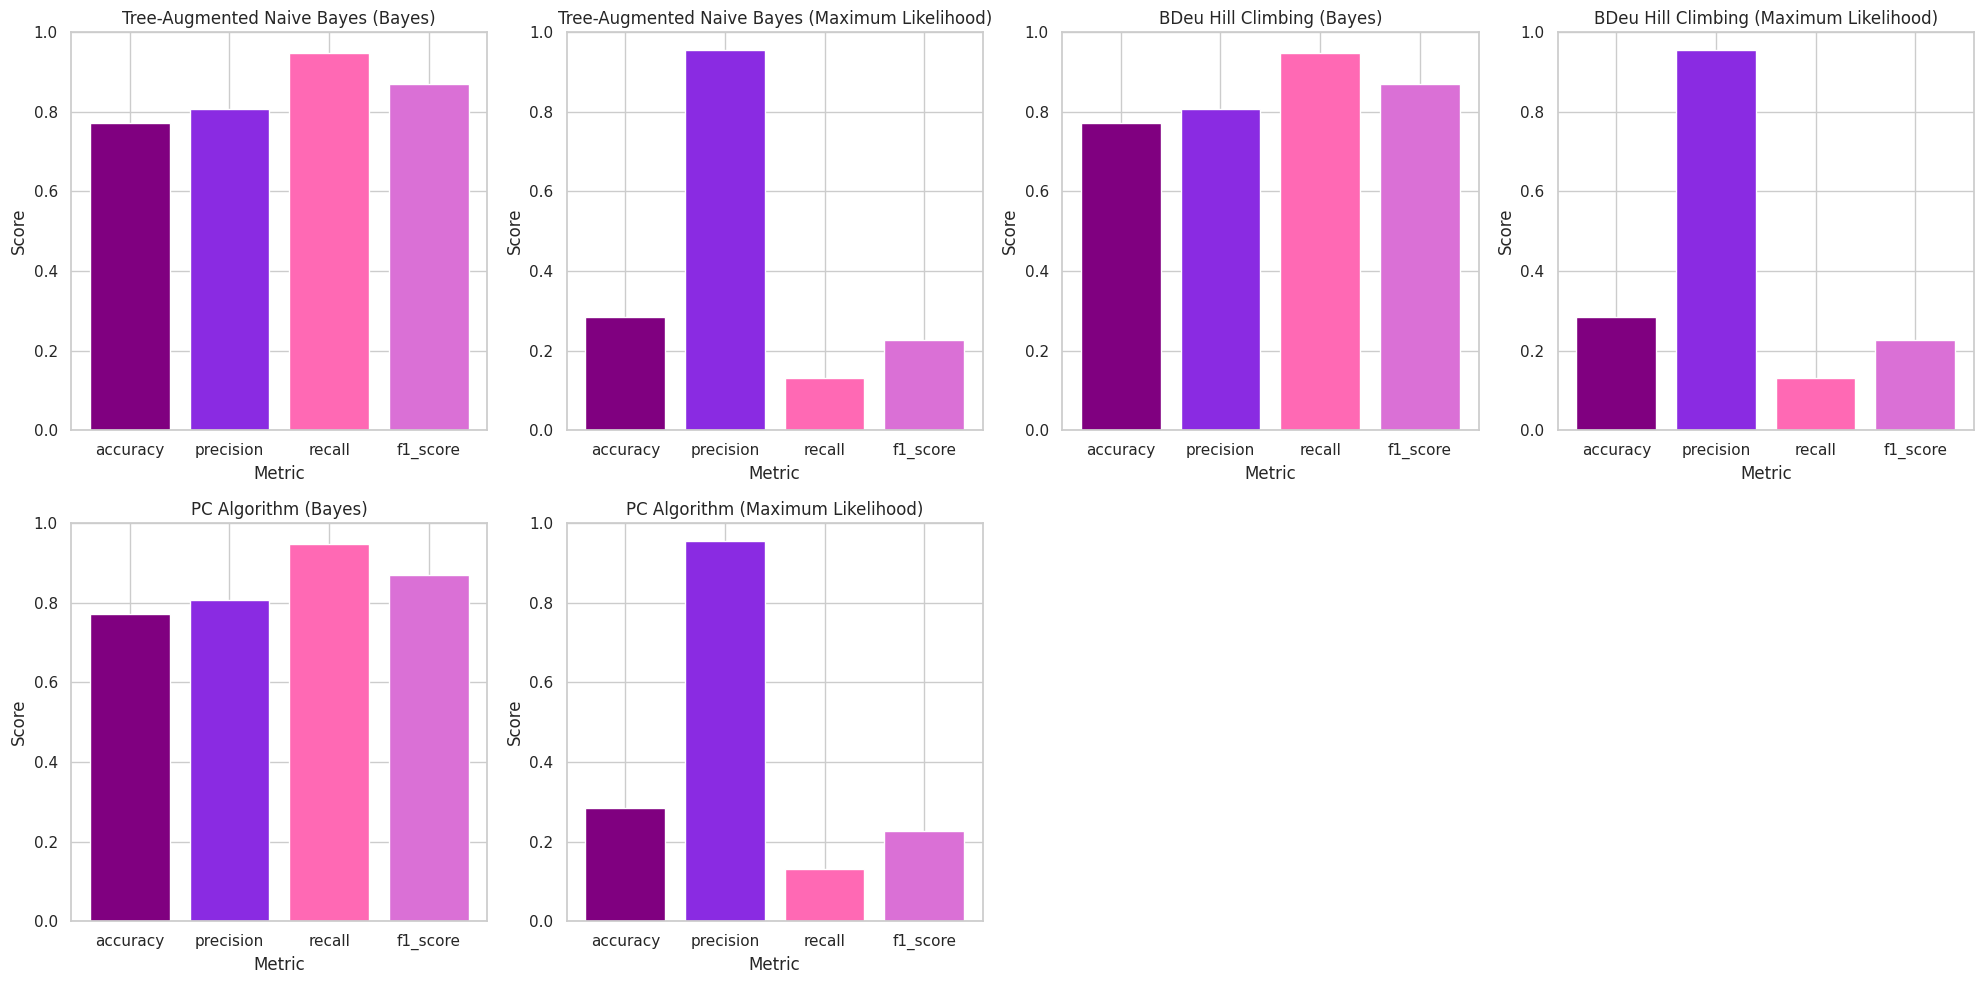

In [63]:
plot_metrics_graphs(metrics)

In [64]:
for method, metrictypes in metrics.items():
    print(f"\n{method}:")
    for metric, value in metrictypes.items():
        if metric in ['accuracy', 'precision', 'recall', 'f1_score']:
            print(f"  {metric.capitalize()}: {value * 100:.2f}%")
        else:
            print(f"  {metric.capitalize()}: {value}")


Tree-Augmented Naive Bayes (Bayes):
  Accuracy: 77.13%
  Precision: 80.63%
  Recall: 94.71%
  F1_score: 86.90%

Tree-Augmented Naive Bayes (Maximum Likelihood):
  Accuracy: 28.55%
  Precision: 95.45%
  Recall: 12.97%
  F1_score: 22.75%

BDeu Hill Climbing (Bayes):
  Accuracy: 77.13%
  Precision: 80.63%
  Recall: 94.71%
  F1_score: 86.90%

BDeu Hill Climbing (Maximum Likelihood):
  Accuracy: 28.55%
  Precision: 95.45%
  Recall: 12.97%
  F1_score: 22.75%

PC Algorithm (Bayes):
  Accuracy: 77.13%
  Precision: 80.63%
  Recall: 94.71%
  F1_score: 86.90%

PC Algorithm (Maximum Likelihood):
  Accuracy: 28.55%
  Precision: 95.45%
  Recall: 12.97%
  F1_score: 22.75%


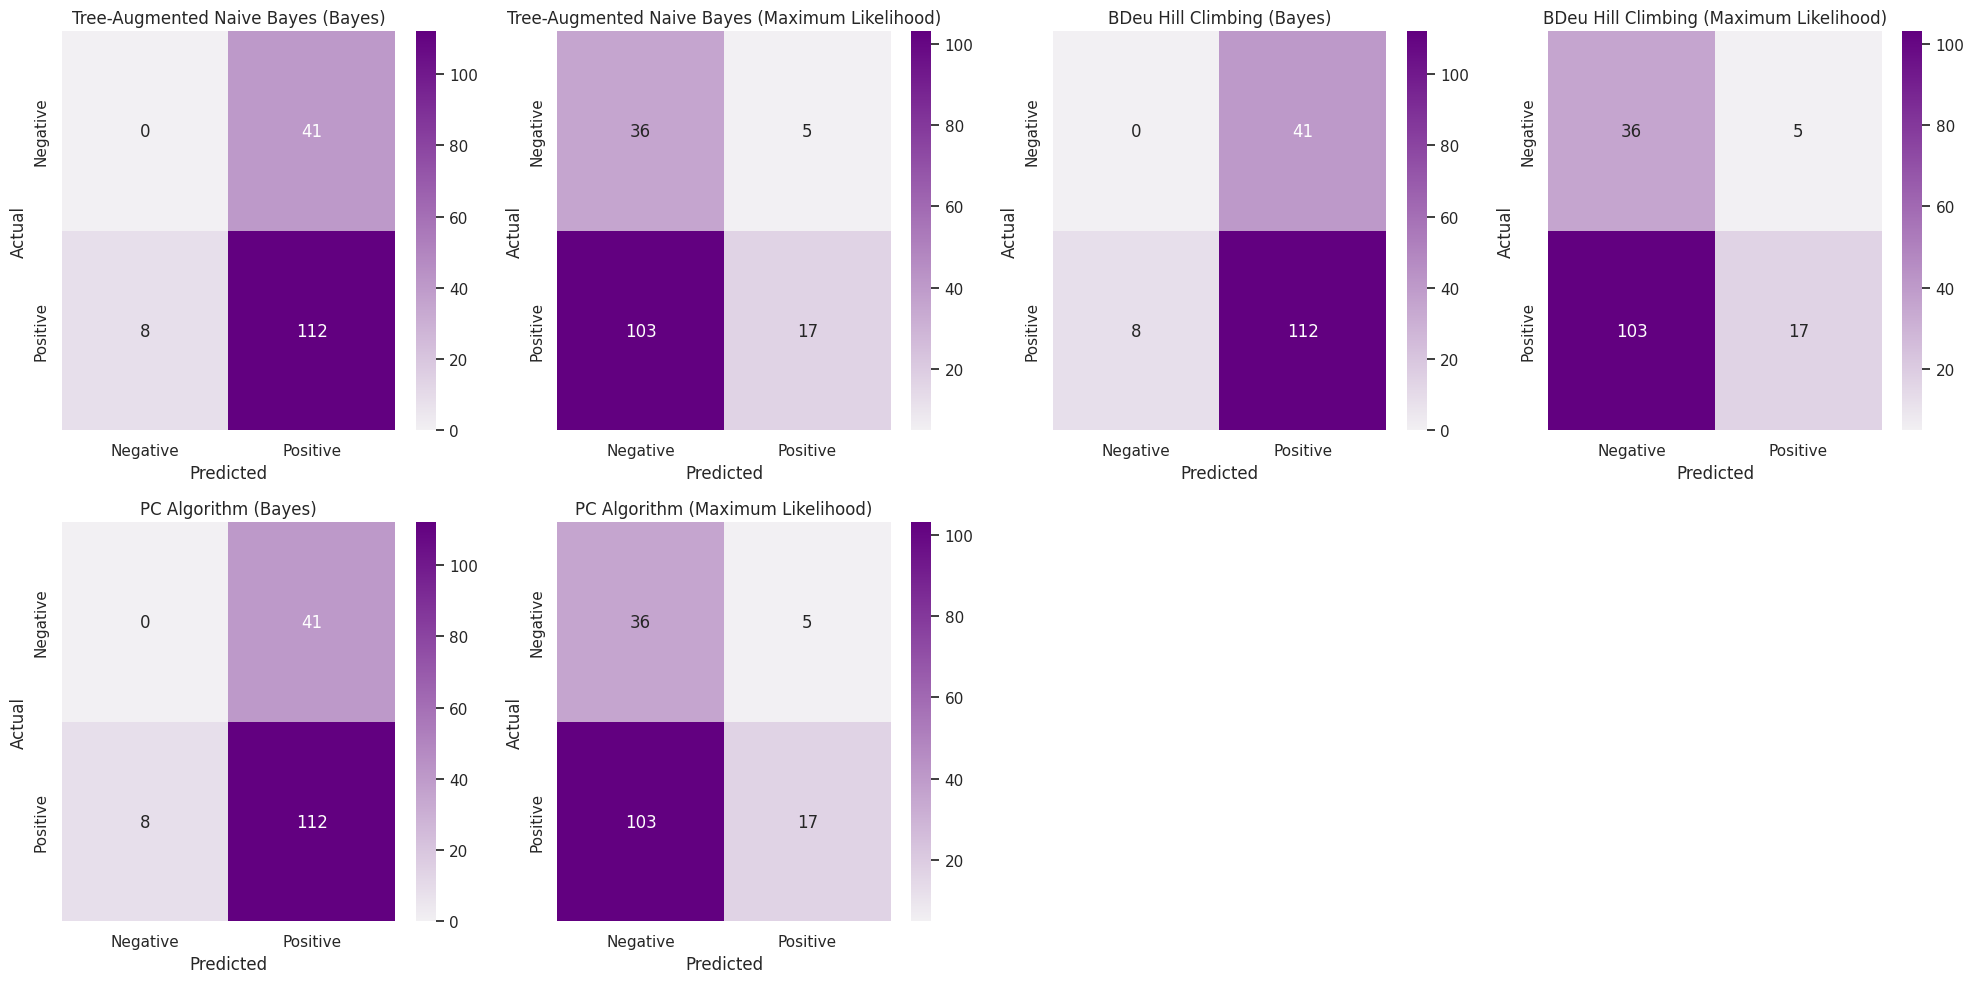

In [65]:
plot_confusion_matrices(confusion, cmap=gradient_palette)